# 🏗️ Calgary Building Permits: Cost Estimation Using Machine Learning

## 🔍 Objective
Predict the **estimated construction cost (`EstProjectCost`)** of Calgary building permits using open data on **472,000+ records**.

---

## 🔑 Key Steps
- Data cleaning, feature engineering, and outlier handling  
- Model training with **XGBoost**, **LightGBM**, **CatBoost**, **Random Forest** and **Stratified Modeling**
- Evaluation using **RMSE** and **R² score**

---

## ✅ Final Outcome
- **Best Model**: XGBoost  
- **RMSE**: ~46,193  
- **R²**: 0.8434  
- The model explains **~85% of cost variance**, supporting **urban planning** and **forecasting** efforts.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install -q bokeh
!pip install -q lightgbm
!pip install -q catboost
!pip install --ignore-installed blinker
!pip install -q xgboost
!pip install -q dash
!pip install -q jupyter-dash
!pip install --upgrade scikit-learn==1.6.1

  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
Using cached blinker-1.9.0-py3-none-any.whl (8.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.8/253.8 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.4 MB/s eta 0:00:00


In [1]:
!pip install openpyxl

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.transform import factor_cmap
from bokeh.palettes import Category20_20, Viridis256
from bokeh.embed import file_html
from bokeh.resources import CDN

# Dash App Components
import dash
from dash import dcc, html
from dash.dependencies import Input, Output

# Statistical Testing
from scipy import stats

# Machine Learning Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing & Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model Persistence
import joblib
from joblib import load

/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## 📂 1. Data Loading

### Dataset Overview
- **Name**: [City of Calgary Building Permits](https://data.calgary.ca/Business-and-Economic-Activity/Building-Permits/c2es-76ed/about_data)  
- **Owner**: Calgary Open Data  
- **Supplier**: City of Calgary, Development Business and Building Services  
- **License**: Open Data Terms  
- **Coverage**: Since **June 22, 1999**  
- **Records**: 472,000+  
- **Columns**: 30 (e.g., `PermitType`, `StatusCurrent`, `ApplicationDate`, `WorkClassGroup`, `EstProjectCost`, `CommunityName`, `TotalSqFt`)


In [3]:
df = pd.read_csv('/content/drive/My Drive/Building Permits/Building_Permits_20250714.csv')
df.head()

,PermitNum,StatusCurrent,AppliedDate,IssuedDate,CompletedDate,PermitType,PermitTypeMapped,PermitClass,PermitClassGroup,PermitClassMapped,...,CommunityCode,CommunityName,Latitude,Longitude,LocationCount,LocationTypes,LocationAddresses,LocationsWKT,LocationsGeoJSON,Point
0,BP2013-09623,Completed,2013/07/08,2013/07/23,2014/01/31,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,...,SAD,SADDLE RIDGE,51.127361,-113.934173,2.0,Titled Parcel;Building,248 SADDLELAKE DR NE;248 SADDLELAKE DR NE,MULTIPOINT (-113.93417287574859 51.12736095642...,"{""type"":""MultiPoint"",""coordinates"":[[-113.9341...",POINT (-113.93417287574859 51.12736095642616)
1,BP2024-19255,Completed,2024/09/11,2024/10/09,2025/04/16,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,...,HSD,HOMESTEAD,51.121259,-113.916497,2.0,Titled Parcel;Building,380 HOMESTEAD GV NE;380 HOMESTEAD GV NE,MULTIPOINT (-113.91649673616925 51.12125920948...,"{""type"":""MultiPoint"",""coordinates"":[[-113.9164...",POINT (-113.91649673616925 51.121259209484535)
2,BP2025-05639,Pre Backfill Phase,2025/04/01,2025/04/16,NaN,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,...,KSH,KEYSTONE HILLS,51.181935,-114.021352,2.0,Building;Building Suite,126 KEYSTONE CREEK PL NE;126R KEYSTONE CREEK P...,MULTIPOINT (-114.02135194116374 51.18193545257...,"{""type"":""MultiPoint"",""coordinates"":[[-114.0213...",POINT (-114.02135194116374 51.18193545257666)
3,BP2023-10028,Completed,2023/06/26,2023/11/16,2024/02/22,Commercial / Multi Family Project,Building,1706 - Rhs Rowhouse,Unspecified,Residential,...,CAR,CARRINGTON,51.178628,-114.080252,3.0,Titled Parcel;Titled Parcel;Titled Parcel,847 CARRINGTON BV NW;839 CARRINGTON BV NW;843 ...,MULTIPOINT (-114.08025209018741 51.17862844089...,"{""type"":""MultiPoint"",""coordinates"":[[-114.0802...",POINT (-114.08025209018741 51.178628440894386)
4,BP2023-11936,Completed,2023/07/25,2023/08/03,2024/02/27,Single Construction Permit,Building,1106 - Single Family House,Single Family,Residential,...,RVW,RANGEVIEW,50.871461,-113.925223,3.0,Titled Parcel;Building;Building Suite,85 MALLARD GV SE;85 MALLARD GV SE;85B MALLARD ...,MULTIPOINT (-113.92522347404321 50.87146078384...,"{""type"":""MultiPoint"",""coordinates"":[[-113.9252...",POINT (-113.92522347404321 50.87146078384628)


## 📊 2. Data Exploration

To begin the analysis, I used:

- `df.info()` – to get a concise summary of the DataFrame:
  - Column names and data types  
  - Non-null counts  
  - Memory usage

- `df.describe(include='all')` – to generate descriptive statistics for all columns:
  - Count, unique values, top values (for categorical features)  
  - Mean, standard deviation, min, max, and percentiles (for numerical features)

This step helps me identify:
- Missing values  
- Columns that may require type conversion  
- Features with low variance or high cardinality


In [4]:
# Display structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471419 entries, 0 to 471418
Data columns (total 30 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PermitNum          471419 non-null  object 
 1   StatusCurrent      471419 non-null  object 
 2   AppliedDate        471419 non-null  object 
 3   IssuedDate         455945 non-null  object 
 4   CompletedDate      448269 non-null  object 
 5   PermitType         471419 non-null  object 
 6   PermitTypeMapped   471419 non-null  object 
 7   PermitClass        471369 non-null  object 
 8   PermitClassGroup   471419 non-null  object 
 9   PermitClassMapped  471419 non-null  object 
 10  WorkClass          471419 non-null  object 
 11  WorkClassGroup     471419 non-null  object 
 12  WorkClassMapped    467455 non-null  object 
 13  Description        428422 non-null  object 
 14  ApplicantName      328709 non-null  object 
 15  ContractorName     282524 non-null  object 
 16  Ho

**Quick Summary from `df.info()`**

- **Rows**: 471,419 | **Columns**: 30  
- Mostly `object` (categorical/text) types  
- Key missing data:
  - `EstProjectCost` (~35K)
  - `TotalSqFt` (~322K)
  - `ContractorName`, `ApplicantName` have many nulls  
- Date columns need conversion from `object` to `datetime`  
- Location fields (`Latitude`, `Longitude`) are complete


In [5]:
# Display descriptive statistics for all columns
df.describe(include='all')

,PermitNum,StatusCurrent,AppliedDate,IssuedDate,CompletedDate,PermitType,PermitTypeMapped,PermitClass,PermitClassGroup,PermitClassMapped,...,CommunityCode,CommunityName,Latitude,Longitude,LocationCount,LocationTypes,LocationAddresses,LocationsWKT,LocationsGeoJSON,Point
count,471419,471419,471419,455945,448269,471419,471419,471369,471419,471419,...,470514,470514,471419.000000,471419.000000,470514.000000,470514,470514,470514,470514,471419
unique,471419,24,7514,7786,7051,5,2,324,16,3,...,314,315,NaN,NaN,NaN,1082,348677,348563,345343,253280
top,BP2025-13529,Completed,2006/05/19,2022/06/29,2015/10/19,Residential Improvement Project,Building,1106 - Single Family House,Single Family,Residential,...,DNC,DOWNTOWN COMMERCIAL CORE,NaN,NaN,NaN,Titled Parcel,222 8 AV SE,POINT (-114.05905337012219 51.04553822759033),"{""type"":""Point"",""coordinates"":[-114.0590534,51...",POINT (-114.00193422649242 51.13440933289924)
freq,1,424716,271,285,512,210992,454972,127391,261026,388268,...,14275,14275,NaN,NaN,NaN,199484,162,162,162,1119
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,50.941053,-113.848035,2.117263,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.236230,4.993835,6.080534,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,-114.304172,1.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,50.949422,-114.123751,1.000000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,51.049327,-114.072009,2.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,51.123739,-113.981312,2.000000,NaN,NaN,NaN,NaN,NaN


**Quick Summary from `df.describe(include='all')`**

- `PermitNum` is unique for every record (acts as a primary key).
- `StatusCurrent` is heavily skewed — "Completed" appears ~425K times.
- High cardinality in several fields:
  - `AppliedDate`, `ContractorName`, `CommunityName`, `LocationAddresses`
- `PermitTypeMapped`, `PermitClassMapped`, and `WorkClassMapped` have only a few unique categories.
- `Latitude` and `Longitude` show expected variation; no extreme outliers, but one `Longitude` is 0.0 (likely an error).
- `LocationCount` varies from 1 to 638
- Fields like `Point`, `GeoJSON`, and `WKT` provide location geometry and are not suitable for modeling without transformation.

This overview guides my next steps in handling high-cardinality features, cleaning geo fields, and encoding categorical data.


### 🧼 Missing Value Analysis

To assess data quality, I calculated the percentage of missing values in each column. This helps in deciding:

- Which features need imputation  
- Which ones have too many missing values and may need to be dropped  
- Which fields can be engineered or flagged

Below is the percentage of missing data in each column (only showing those with null values):


In [6]:
# Calculate missing values count and percentage
missing_count = df.isnull().sum()
missing_percent = 100 * df.isnull().sum() / len(df)

# Combine into one DataFrame
missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percent
})

# Filter columns that have any missing values (optional)
missing_df = missing_df[missing_df['Missing Count'] > 0]

# Sort by percentage descending
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)

# Display
print(missing_df)

                   Missing Count  Missing Percentage
TotalSqFt                 322410           68.391389
ContractorName            188895           40.069450
ApplicantName             142710           30.272433
Description                42997            9.120761
EstProjectCost             34714            7.363725
CompletedDate              23150            4.910706
IssuedDate                 15474            3.282430
WorkClassMapped             3964            0.840866
OriginalAddress              905            0.191974
LocationTypes                905            0.191974
CommunityCode                905            0.191974
CommunityName                905            0.191974
LocationCount                905            0.191974
LocationsWKT                 905            0.191974
LocationAddresses            905            0.191974
LocationsGeoJSON             905            0.191974
PermitClass                   50            0.010606


/tmp/ipython-input-1259361320.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.values, y=missing_percent.index, palette="viridis")


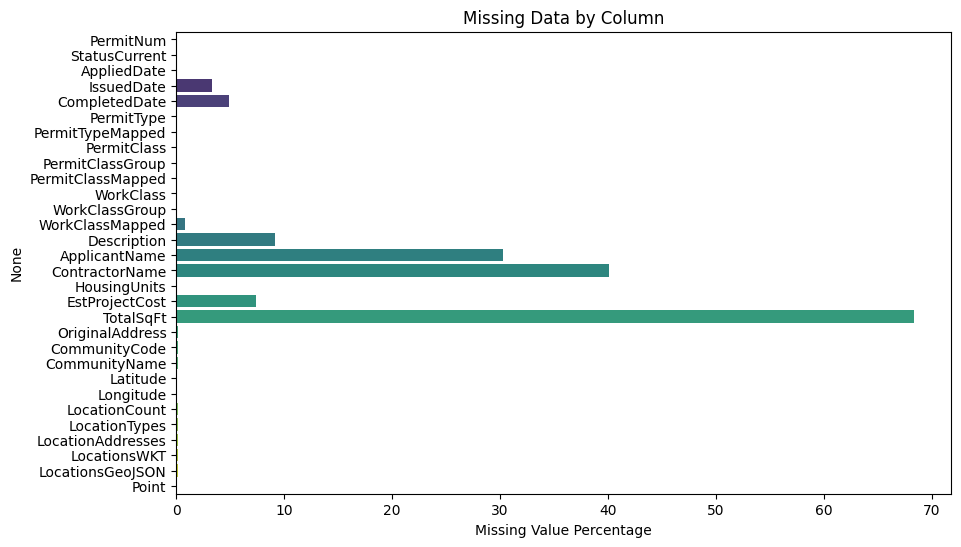

In [7]:
# Visualize missing data
plt.figure(figsize=(10,6))
sns.barplot(x=missing_percent.values, y=missing_percent.index, palette="viridis")
plt.xlabel("Missing Value Percentage")
plt.title("Missing Data by Column")
plt.show()

## 🧹 3. Data Cleaning & Preprocessing

### 🔹 3.1 Remove Records with Missing Target
Dropped rows with missing `EstProjectCost` since it's the target variable.

In [8]:
initial_count = len(df)
df = df.dropna(subset=['EstProjectCost'])
final_count = len(df)
print(f"Dropped {initial_count - final_count} rows with missing EstProjectCost.")

Dropped 34714 rows with missing EstProjectCost.


In [9]:
df = df[df['EstProjectCost'] > 0]
df.shape

(436696, 30)

In [10]:
df['EstProjectCost'].isna().sum()

np.int64(0)

In [11]:
print(df['EstProjectCost'].describe())
#df.to_csv('BP_cleaned_data.csv', index=False, lineterminator='\n')
df.to_excel('BP_cleaned_data.xlsx', index=False)

count    4.366960e+05
mean     2.683817e+05
std      3.405204e+06
min      1.000000e+00
25%      1.517100e+04
50%      5.414500e+04
75%      1.975348e+05
max      8.682552e+08
Name: EstProjectCost, dtype: float64


In [12]:
# Calculate missing values count and percentage
missing_count = df.isnull().sum()
missing_percent = 100 * df.isnull().sum() / len(df)

# Combine into one DataFrame
missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage': missing_percent
})

# Filter columns that have any missing values (optional)
missing_df = missing_df[missing_df['Missing Count'] > 0]

# Sort by percentage descending
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False)

# Display
print(missing_df)
missing_df.to_excel('missing_data.xlsx')

                   Missing Count  Missing Percentage
TotalSqFt                 289881           66.380503
ContractorName            175373           40.159058
ApplicantName             128747           29.482065
Description                23095            5.288576
CompletedDate              21465            4.915319
IssuedDate                  4432            1.014894
WorkClassMapped             3258            0.746057
OriginalAddress               14            0.003206
CommunityCode                 14            0.003206
CommunityName                 14            0.003206
LocationCount                 14            0.003206
LocationTypes                 14            0.003206
LocationAddresses             14            0.003206
LocationsWKT                  14            0.003206
LocationsGeoJSON              14            0.003206


### 🔹 3.2 Convert Date Columns
Converted `AppliedDate`, `IssuedDate`, and `CompletedDate` from object to datetime format for easier temporal feature engineering.

In [13]:
df['AppliedDate'] = pd.to_datetime(df['AppliedDate'])
df['IssuedDate'] = pd.to_datetime(df['IssuedDate'])
df['CompletedDate'] = pd.to_datetime(df['CompletedDate'])

### 🔹 3.3 Create Duration Columns

To capture permit processing times, I created two new duration features:

- **Approval Duration** = `IssuedDate` − `AppliedDate`  
- **Completion Duration** = `CompletedDate` − `IssuedDate`

These features provide insight into approval speed and project timelines.


In [14]:
# Create duration features (in days)
df['ApprovalDuration'] = (df['IssuedDate'] - df['AppliedDate']).dt.days
df['CompletionDuration'] = (df['CompletedDate'] - df['IssuedDate']).dt.days

In [15]:
df[['ApprovalDuration', 'CompletionDuration']].describe()

,ApprovalDuration,CompletionDuration
count,432264.000000,414766.000000
mean,22.238845,252.587611
std,48.021763,316.403327
min,-6.000000,-630.000000
25%,1.000000,68.000000
50%,14.000000,162.000000
75%,27.000000,295.000000
max,4684.000000,6768.000000


### 📊 Duration Feature Summary

- **ApprovalDuration**
  - Mean: ~22 days | Median: 14 days
  - 75% of permits are approved within ~27 days
  - Some records have negative durations (min: -6), indicating possible data entry or date issues

- **CompletionDuration**
  - Mean: ~253 days | Median: 162 days
  - Some extremely high durations (max: 6768 days ≈ 18.5 years)
  - Negative values (min: -630) are also present, suggesting data inconsistencies

I will handle negative and extreme values in the next cleaning step to ensure modeling accuracy.


### 📊 2. Exploratory Data Analysis (EDA)

#### 🔍 Distribution of Estimated Project Cost

We begin our EDA by visualizing the distribution of `EstProjectCost` to understand the spread and central tendency of project costs in our dataset. This will help identify skewness, outliers, and typical cost ranges.

#### 📌 Key Insights:
- The distribution shows whether the cost data is **skewed** (e.g., right-skewed with many small projects and few large ones).
- Look for **outliers** or unexpected spikes in frequency.
- Summary statistics (mean, median, standard deviation, etc.) provide a quick understanding of the overall cost trends.
- This sets the foundation for deeper insights and future feature engineering.

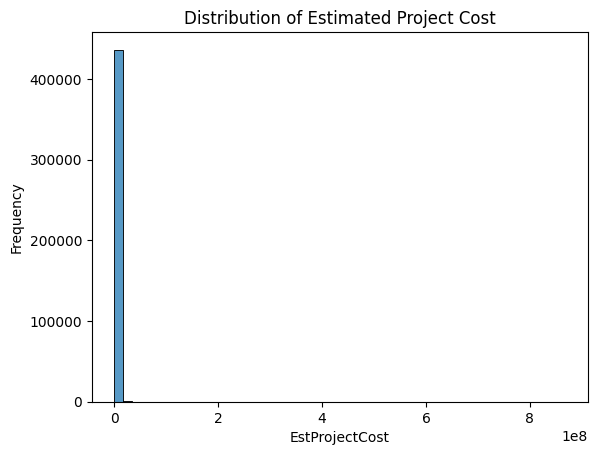

count    4.366960e+05
mean     2.683817e+05
std      3.405204e+06
min      1.000000e+00
25%      1.517100e+04
50%      5.414500e+04
75%      1.975348e+05
max      8.682552e+08
Name: EstProjectCost, dtype: float64


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['EstProjectCost'], bins=50)
plt.title('Distribution of Estimated Project Cost')
plt.xlabel('EstProjectCost')
plt.ylabel('Frequency')
plt.show()

print(df['EstProjectCost'].describe())


#### 📊 Interpretation of Estimated Project Cost Summary

- Count: 436,696 projects have cost data available.
- Mean: The average estimated project cost is about \$268,381.
- Std Dev: The large standard deviation (~3.4 million) indicates wide variation in project costs.
- Min: Some projects are very cheap or possibly symbolic (minimum cost = \$1).
- 25th Percentile: 25% of projects cost less than ~\$15,171.
- Median (50th Percentile): Half of the projects cost less than ~\$54,145.
- 75th Percentile: 25% of projects cost more than ~\$197,535.
- Max: The maximum project cost is extremely high (~\$868 million), which may be an outlier or a mega-project.


### 📦 Estimated Project Cost by Permit Type

This boxplot shows the distribution of project costs for each permit type. The y-axis is limited to 500,000 to focus on the bulk of the data and reduce the influence of extreme outliers.


In [17]:
df['PermitType'].value_counts()

,count
PermitType,
Residential Improvement Project,199161
Single Construction Permit,146815
Commercial / Multi Family Project,90119
Environmental Restoration Permit,601


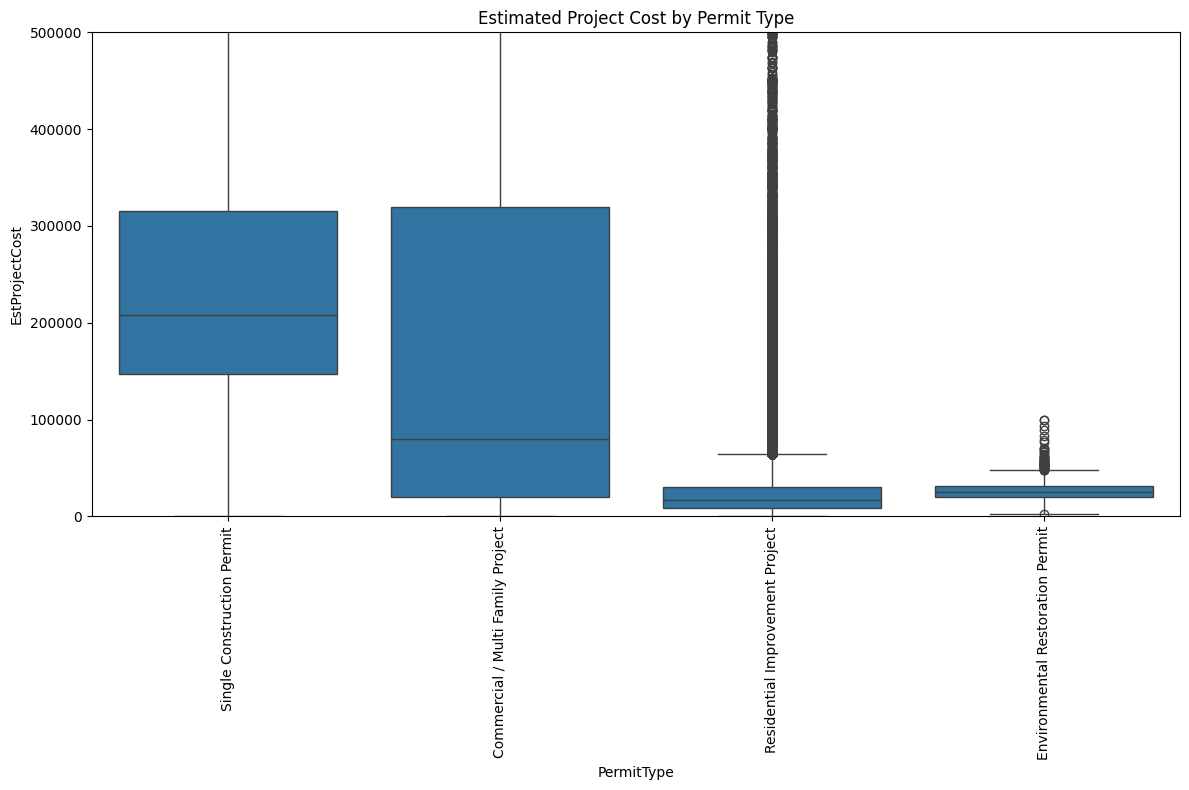

In [18]:
plt.figure(figsize=(12,8))
sns.boxplot(x='PermitType', y='EstProjectCost', data=df)
plt.ylim(0, 500_000)
plt.xticks(rotation=90)
plt.title("Estimated Project Cost by Permit Type")
plt.tight_layout()
plt.show()


#### Insights
- Most permit types have project costs clustered well below \$500,000.
- Some permit types show wider variability and potential outliers near the upper limit.
- The boxplot helps identify which permit types tend to have higher typical costs.
- Extreme outliers above \$500,000 are excluded here but should be investigated separately.
- Next, we could explore:
  - Log-transforming `EstProjectCost` to better visualize all data including outliers.

### Log-Transformed Estimated Project Cost

Applying a log transformation helps normalize the highly skewed distribution of project costs and reduces the impact of extreme outliers.


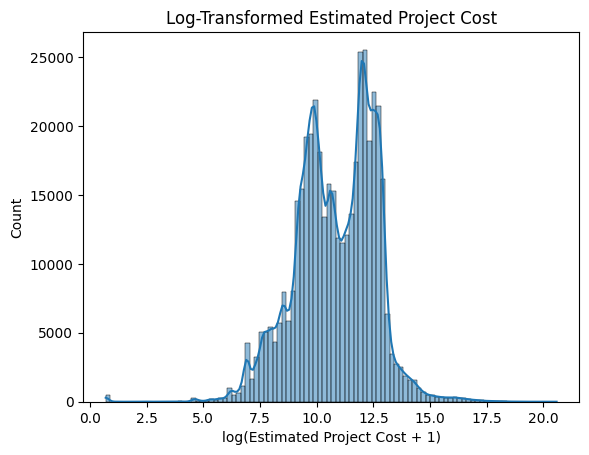

In [19]:
# Create a transformed column
df['LogEstProjectCost'] = np.log1p(df['EstProjectCost'])  # log1p handles zeros

sns.histplot(df['LogEstProjectCost'], bins=100, kde=True)
plt.title('Log-Transformed Estimated Project Cost')
plt.xlabel('log(Estimated Project Cost + 1)')
plt.ylabel('Count')
plt.show()

### Log-Transformed Estimated Project Cost by Permit Type

Using the log transformation allows better visualization of cost differences across permit types by compressing large outliers.


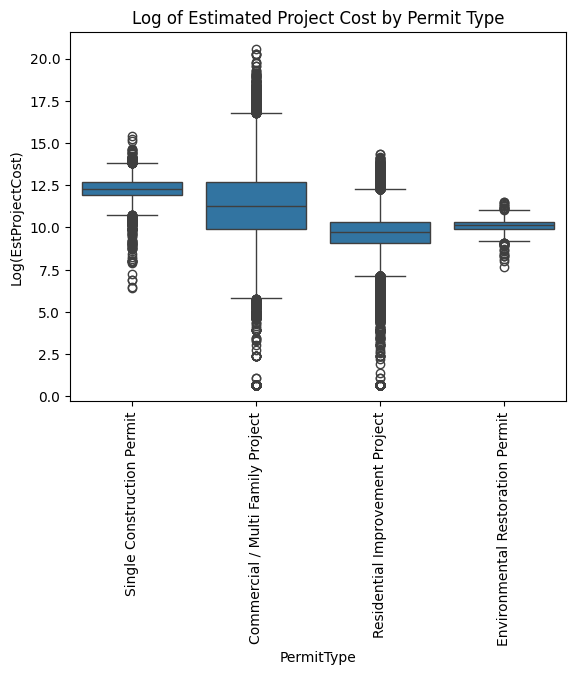

In [20]:
sns.boxplot(x='PermitType', y='LogEstProjectCost', data=df)
plt.xticks(rotation=90)
plt.title("Log of Estimated Project Cost by Permit Type")
plt.ylabel("Log(EstProjectCost)")
plt.show()

In [21]:
print(df['LogEstProjectCost'].describe())

count    436696.000000
mean         10.831039
std           1.777948
min           0.693147
25%           9.627207
50%          10.899439
75%          12.193675
max          20.581996
Name: LogEstProjectCost, dtype: float64


#### Summary Statistics for Log-Transformed Estimated Project Cost

- Count: 436,696 projects  
- Mean: 10.83  
- Std Dev: 1.78  
- Min: 0.69 (log of 1)  
- 25th Percentile: 9.63  
- Median (50th Percentile): 10.90  
- 75th Percentile: 12.19  
- Max: 20.58  

These values show the compressed range of costs after log transformation, making the data more normally distributed and easier to analyze.


### Outlier Detection on Log-Transformed Estimated Project Cost

**Objective:**  
To identify unusually low or high project costs using the interquartile range (IQR) method on the log-transformed cost data. This helps flag projects whose costs deviate significantly from the typical range.

**Method:**  
- Calculate the 1st quartile (Q1) and 3rd quartile (Q3) of `LogEstProjectCost`.
- Compute the interquartile range (IQR = Q3 - Q1).
- Define lower and upper bounds as Q1 - 1.5*IQR and Q3 + 1.5*IQR.
- Projects outside these bounds are considered outliers.


In [22]:
# Calculate IQR bounds for LogEstProjectCost
Q1 = df['LogEstProjectCost'].quantile(0.25)
Q3 = df['LogEstProjectCost'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter rows considered as outliers based on LogEstProjectCost
outliers = df[(df['LogEstProjectCost'] < lower_bound) | (df['LogEstProjectCost'] > upper_bound)]

print("Total Outliers:", outliers.shape[0])

# Select relevant columns for deeper inspection
cols_to_inspect = ['EstProjectCost', 'LogEstProjectCost', 'TotalSqFt', 'PermitType', 'PermitClass', 'WorkClass','Description']

# Show the first few outlier rows with relevant info
outliers[cols_to_inspect].sort_values(by='LogEstProjectCost', ascending=False).head(10)

Total Outliers: 3091


,EstProjectCost,LogEstProjectCost,TotalSqFt,PermitType,PermitClass,WorkClass,Description
306846,868255213.0,20.581996,NaN,Commercial / Multi Family Project,5201 - Hospital,New,New Calgary Cancer Center: 13 storey building ...
20807,644689500.0,20.284279,NaN,Commercial / Multi Family Project,3402 - Office,New,New Commercial Project
437963,639048958.0,20.275492,NaN,Commercial / Multi Family Project,3502 - Arena,New,NaN
464919,639048958.0,20.275492,NaN,Commercial / Multi Family Project,3511 - Stadium,New,NaN
162297,596614379.0,20.206782,NaN,Commercial / Multi Family Project,2308 - Terminal-Air,Addition,Airport Expansion/Hotel
135465,400000000.0,19.806975,NaN,Commercial / Multi Family Project,3203 - Warehouse,New,YYC 4 - Project Maverick
266989,376000000.0,19.745100,NaN,Commercial / Multi Family Project,3402 - Office,New,New 58 storey building and parkade
244077,371926500.0,19.734207,NaN,Commercial / Multi Family Project,5201 - Hospital,New,NEW HOSPITAL
292578,320000000.0,19.583832,NaN,Commercial / Multi Family Project,3402 - Office,New,"NEW COMMERCIAL BUILDING(EAST TOWER, PARKADE, A..."
439052,316961700.0,19.574292,NaN,Commercial / Multi Family Project,3508 - Exhibition Building,Addition,BMO Expansion Addition - Convention Centre


### Outlier Analysis Summary
- **Results:**  
  - Total outliers found: 3,091  
  - Most extreme projects are very large commercial or multi-family developments such as hospitals, office towers, stadiums, and airports.  
  - Estimated project costs range up to over \$868 million.

- **Insights:**  
  - These outliers represent mega-projects with very high costs compared to typical permits.  
  - They can significantly affect model training and data summaries if not handled properly.  
  - Depending on the analysis goal, consider treating these outliers separately, capping values, or using robust modeling techniques.  
  - Some outliers have missing or vague descriptions, which may need further data cleaning or validation.

This analysis helps in making informed decisions on how to handle large-scale projects in downstream tasks.

### Cleaning Low-Cost Suspicious Records

- Removed records with estimated cost ≤ 20, missing descriptions, and common placeholder work classes.
- These likely represent incomplete or erroneous data.
- Cleaning improves dataset quality for analysis and modeling.


In [23]:
# Identify low-cost rows
low_cost_df = df[df['EstProjectCost'] <= 20]

# Further filter rows with missing descriptions
low_cost_missing_desc_df = low_cost_df[low_cost_df['Description'].isna()]

# Flag suspicious work classes
suspicious_work_classes = ['New', 'Alteration', 'Repair', 'Addition', 'Temporary']
flagged_df = low_cost_missing_desc_df[low_cost_missing_desc_df['WorkClass'].isin(suspicious_work_classes)]

# Save flagged rows to CSV if you'd like (optional)
flagged_df.to_csv("flagged_low_cost_rows.csv", index=False)
print(f"Flagged rows saved to 'flagged_low_cost_rows.csv' (total: {flagged_df.shape[0]} rows).")

# Drop flagged rows from df
df = df.drop(flagged_df.index)

# Reset index to keep it clean
df = df.reset_index(drop=True)

print(f"DataFrame updated! New shape: {df.shape}")

Flagged rows saved to 'flagged_low_cost_rows.csv' (total: 56 rows).
DataFrame updated! New shape: (436640, 33)


In [24]:
df[df['EstProjectCost']<=20]['Description']

,Description
58,Change of use.
197,Secondary Suite
635,Change of use (Automotive minor).
852,Interior alterations - Awae
1046,Interior alterations
...,...
433254,First tenant fit out - CALGARY CO-OP CANNABIS ...
433340,Tenancy change
435066,Tenancy Change
435201,Improvements


## 📊 Aggregated Analysis & Business Questions

This section explores high-level trends and patterns in building permit data using groupby, aggregation, and visualization techniques. These insights can support data-driven decision-making for urban planning and infrastructure development.

---

### ❓ Q1. Are Permit Volumes Increasing or Decreasing Over Time?

**Objective:**  
Assess trends in the number of permits applied over the years.

**Approach:**  
- Extract year from the `AppliedDate`.
- Group by year and count total permits.
- Visualize using a line plot.


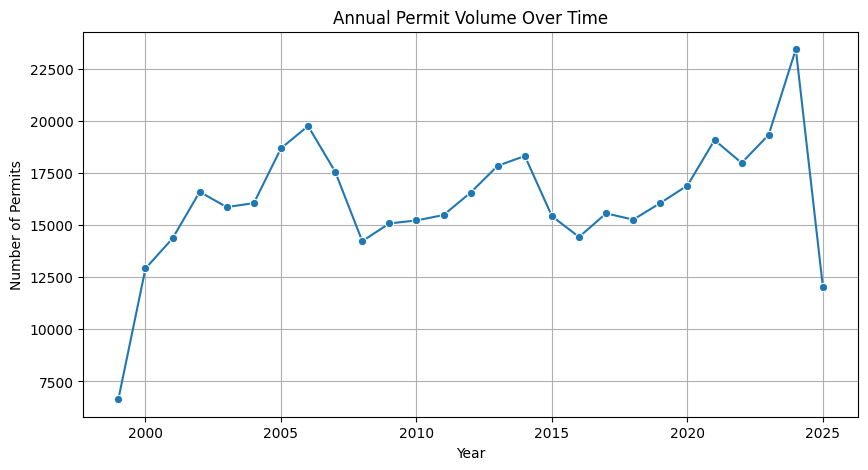

In [25]:
# Convert date column to datetime if not already
df['AppliedDate'] = pd.to_datetime(df['AppliedDate'])

# Extract year from AppliedDate
df['AppliedYear'] = df['AppliedDate'].dt.year

# Group by year and count number of permits
yearly_counts = df.groupby('AppliedYear').size().reset_index(name='PermitCount')

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=yearly_counts, x='AppliedYear', y='PermitCount', marker='o')
plt.title('Annual Permit Volume Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Permits')
plt.grid(True)
plt.show()


**Insights:**

- Permit volumes generally show an **increasing trend** from 1999 to 2024, reflecting growth in construction and development activities.
- There are some fluctuations, such as dips around 2008-2010, likely corresponding to economic downturns.
- The sharp increase in 2024 could indicate a construction boom or data reporting differences.
- Partial data for 2025 shows a lower count, probably due to incomplete reporting year-to-date.

This trend analysis supports urban planning efforts by revealing periods of heightened or reduced building activity over time.

### ❓ Q2.  Which work classes have the highest median estimated project costs in Calgary building permits?
- Group by WorkClass and calculate median EstProjectCost.
- Sort and plot as an interactive Bokeh bar chart with hover details.


In [26]:
output_notebook()

# Step 1: Group and prepare data
workclass_costs = df.groupby('WorkClass')['EstProjectCost'].median().reset_index()
workclass_costs = workclass_costs.sort_values(by='EstProjectCost', ascending=False)

# Step 2: Set up data source
source = ColumnDataSource(workclass_costs)

# Step 3: Define color palette (you can customize)
palette = factor_cmap('WorkClass', palette='Viridis256', factors=workclass_costs['WorkClass'])

# Step 4: Create figure
p = figure(x_range=workclass_costs['WorkClass'],
           height=400, width=800,
           title="💰 Median Estimated Project Cost by Work Class",
           toolbar_location="above", tools="pan,box_zoom,reset,save")

p.vbar(x='WorkClass', top='EstProjectCost', width=0.8, source=source, fill_color=palette)

# Step 5: Add hover tool
hover = HoverTool(tooltips=[("WorkClass", "@WorkClass"), ("Median Cost", "@EstProjectCost{0,0}")])
p.add_tools(hover)

# Beautify
p.xaxis.major_label_orientation = 1.2
p.xgrid.grid_line_color = None
p.yaxis.axis_label = "Median Estimated Project Cost"

# Show the plot
show(p)

## 💡 Insight: Median Estimated Project Cost by Work Class
Based on the aggregated data, the median estimated costs vary significantly across work classes:

- 🔧 **"New" constructions and HVAC installations** (Air Conditioning) are the most capital-intensive work classes, with median costs well above $150K.
- 🛠️ **"Repair," "Addition," and "Alteration"** classes show **moderate costs** (ranging from ~\$20K to ~\$35K), typical for residential renovations or modifications.
- 🚨 **"Fire/Security Alarm"** and **"Temporary"** permits are at the lower end, often reflecting **small-scale, time-bound, or equipment-only installations** costs under \$10K.

These insights help prioritize which permit types are cost-intensive and require closer financial oversight.


### ❓ Q3. Relationship Between Average Estimated Project Cost and Average Housing Units by Permit Class Group

**Objective:**  
Explore how the average project cost correlates with the average number of housing units across different permit class groups.

**Approach:**  
- Group data by `PermitClassGroup`.
- Calculate average estimated project cost and average number of housing units.
- Visualize with a scatter plot to identify trends or correlations.

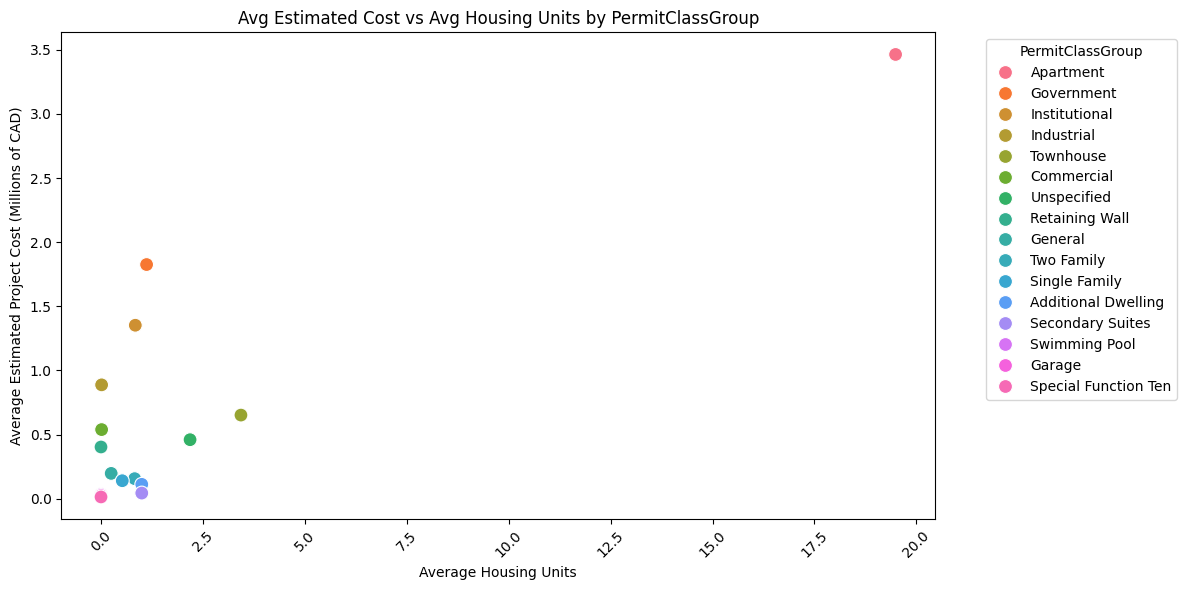

In [27]:
grouped = df.groupby('PermitClassGroup').agg({
    'EstProjectCost': 'mean',
    'HousingUnits': 'mean',
    'PermitNum': 'count'  # Optional: to see volume of permits
}).sort_values(by='EstProjectCost', ascending=False)

grouped.rename(columns={
    'EstProjectCost': 'AvgCost',
    'HousingUnits': 'AvgHousingUnits',
    'PermitNum': 'PermitCount'
}, inplace=True)

# Convert AvgCost to millions
grouped['AvgCost'] = grouped['AvgCost'] / 1_000_000

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=grouped,
    x='AvgHousingUnits',
    y='AvgCost',
    hue=grouped.index,
    s=100
)

plt.title('Avg Estimated Cost vs Avg Housing Units by PermitClassGroup')
plt.xlabel('Average Housing Units')
plt.ylabel('Average Estimated Project Cost (Millions of CAD)')
plt.xticks(rotation=45)
plt.legend(title='PermitClassGroup', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [28]:
grouped

,AvgCost,AvgHousingUnits,PermitCount
PermitClassGroup,,,
Apartment,3.463876,19.488722,6118
Government,1.825973,1.118005,822
Institutional,1.352712,0.841125,8321
Industrial,0.887962,0.014816,4927
Townhouse,0.652317,3.432631,9641
Commercial,0.539231,0.014961,56479
Unspecified,0.460365,2.184308,2957
Retaining Wall,0.403534,0.000000,87
General,0.197668,0.249663,2227


### 💡 Insight: Average Project Cost and Housing Units by Permit Class Group

- **Apartments and Government projects** have the **highest average project costs** and the greatest average number of housing units, reflecting large-scale developments.
- **Institutional and Industrial** projects also have relatively high costs but fewer housing units on average.
- **Townhouses and Two Family homes** show moderate costs and moderate average housing units.
- **Single Family homes** represent the largest volume of permits but have relatively low average project costs and housing units.
- Low-cost permit classes such as **Garages, Swimming Pools, and Secondary Suites** have near-zero average housing units, indicating accessory or minor construction.

This relationship indicates that as average housing units increase, so does the average estimated project cost, with some variation depending on permit type and scale.


### ❓ Q4. Which Communities Have the Highest Total Investment in Projects? (in Millions)

**Objective:**  
Identify communities with the largest total project investments, expressed in millions of dollars for clarity.

**Approach:**  
- Aggregate total estimated project cost by community.
- Convert amounts to millions.
- Sort and visualize top 10 communities.

In [29]:
# Aggregate total cost by community
community_investment = df.groupby('CommunityName')['EstProjectCost'].sum().reset_index()

# Convert to millions
community_investment['EstProjectCost_Million'] = community_investment['EstProjectCost'] / 1_000_000

# Sort descending
top_communities = community_investment.sort_values(by='EstProjectCost_Million', ascending=False).head(10)

# Plot

output_notebook()

# Prepare data source
source = ColumnDataSource(top_communities)

# Define color palette
#palette = 'Mako256'  # Bokeh's 'Mako' palette

# Create figure
p = figure(
    x_range=top_communities['CommunityName'].tolist(),
    height=600, width=800,
    title="Top 10 Communities by Total Estimated Project Cost (in Millions)",
    toolbar_location="above",
    tools="pan,box_zoom,reset,save"
)
# Add bars
p.vbar(
    x='CommunityName',
    top='EstProjectCost_Million',
    width=0.8,
    source=source,
    fill_color=factor_cmap('CommunityName', palette=Category20_20,  factors=top_communities['CommunityName'])
)

# Add hover tool
hover = HoverTool(tooltips=[
    ("Community", "@CommunityName"),
    ("Total Investment", "@EstProjectCost_Million{0,0.00} Million CAD")
])
p.add_tools(hover)

# Customize plot
p.xaxis.major_label_orientation = 1.2  # Rotate labels
p.xgrid.grid_line_color = None
p.yaxis.axis_label = "Total Estimated Project Cost (Million CAD)"

show(p)

In [30]:
top_communities

,CommunityName,EstProjectCost,EstProjectCost_Million
67,DOWNTOWN COMMERCIAL CORE,8.831842e+09,8831.841719
18,BELTLINE,6.894199e+09,6894.198562
250,SETON,2.557712e+09,2557.712092
136,MAHOGANY,2.436524e+09,2436.523990
72,EAST SHEPARD INDUSTRIAL,2.305721e+09,2305.720504
242,SADDLE RIDGE,2.023049e+09,2023.049385
55,CRANSTON,1.947743e+09,1947.742578
80,EVANSTON,1.839625e+09,1839.625476
270,ST. ANDREWS HEIGHTS,1.811110e+09,1811.110043
28,CALGARY INTERNATIONAL AIRPORT,1.786257e+09,1786.257490


### Insight: Top Communities by Project Investment

This visualization highlights the **top 10 Calgary communities** with the highest **total estimated project costs (in millions)** based on building permits data.
- **Downtown Commercial Core** leads with a **total investment of \$8.83 billion**, driven by dense commercial and mixed-use projects.  
- **Beltline** follows with **\$6.89 billion**, reflecting vibrant urban development.  
- **Seton**, **Mahogany**, and **East Shepard Industrial** each exceeded **\$2 billion**, showcasing rapid residential and industrial expansion.  
- Other notable areas include **Saddle Ridge**, **Cranston**, **Evanston**, **St. Andrews Heights**, and the **Calgary International Airport** zone, indicating significant suburban, institutional, and infrastructure developments.

📌 This data supports the narrative of **balanced urban revitalization and suburban growth** in Calgary.


### ❓ Q5: Which combinations of Permit Type and Work Class tend to get approved the fastest on average?

**Objective:**  
To identify the Permit Type and Work Class pairs with the shortest average approval durations, helping to understand where the approval process is most efficient.

**Approach:**  
- Group building permits by `PermitType` and `WorkClass`.
- Calculate the average approval duration and count of permits for each group.
- Filter for groups with sufficient volume (more than 100 permits) to ensure statistical significance.
- Visualize the top 15 fastest combinations using a horizontal bar chart.



In [31]:
# Enable Bokeh output in notebook
output_notebook()

# Step 1: Drop rows with missing ApprovalDuration or key fields
df_clean = df.dropna(subset=['ApprovalDuration', 'PermitType', 'WorkClass'])

# Step 2: Group by PermitType and WorkClass, calculate mean ApprovalDuration and count
approval_combo = df_clean.groupby(['PermitType', 'WorkClass']).agg({
    'ApprovalDuration': 'mean',
    'PermitNum': 'count'
}).reset_index()

# Step 3: Rename columns for clarity
approval_combo.rename(columns={
    'ApprovalDuration': 'AvgApprovalDays',
    'PermitNum': 'PermitCount'
}, inplace=True)

# Step 4: Filter combinations with sufficient data
approval_combo = approval_combo[approval_combo['PermitCount'] > 100]

# Step 5: Select top 15 fastest combinations
top_fastest = approval_combo.sort_values('AvgApprovalDays').head(15).copy()
top_fastest['Label'] = top_fastest['PermitType'] + " | " + top_fastest['WorkClass']
top_fastest = top_fastest.sort_values('AvgApprovalDays', ascending=True)

# Step 6: Prepare data for Bokeh
source = ColumnDataSource(top_fastest)

# Step 7: Create Bokeh horizontal bar chart
p = figure(
    y_range=top_fastest['Label'],
    height=400,
    width=700,
    title="Fastest Approved PermitType & WorkClass",
    x_axis_label="Avg Approval Duration (Days)",
    tools="pan,box_zoom,reset,save"
)

# Add bars
p.hbar(
    y='Label',
    right='AvgApprovalDays',
    height=0.35,
    source=source,
    color=factor_cmap('Label', palette=Category20_20, factors=top_fastest['Label'])
)

# Add hover tooltip
hover = HoverTool(tooltips=[
    ("Permit Type", "@PermitType"),
    ("Work Class", "@WorkClass"),
    ("Avg Approval Days", "@AvgApprovalDays{0.0}"),
    ("Permit Count", "@PermitCount")
])
p.add_tools(hover)

# Aesthetic improvements
p.ygrid.grid_line_color = None
p.x_range.start = 0
p.title.text_font_size = '13pt'
p.xaxis.axis_label_text_font_size = "11pt"
p.yaxis.major_label_text_font_size = "9pt"

# Step 8: Show plot
show(p)
approval_combo

,PermitType,WorkClass,AvgApprovalDays,PermitCount
0,Commercial / Multi Family Project,Addition,69.030147,2521
2,Commercial / Multi Family Project,Alteration,31.523050,62472
3,Commercial / Multi Family Project,Fire/ Security Alarm,12.194792,1997
4,Commercial / Multi Family Project,New,67.264622,17251
5,Commercial / Multi Family Project,Repair,19.044245,3006
6,Commercial / Multi Family Project,Temporary,20.355976,1163
7,Environmental Restoration Permit,Alteration,185.671875,576
10,Residential Improvement Project,Addition,23.347797,13482
11,Residential Improvement Project,Alteration,8.780394,120935
12,Residential Improvement Project,New,14.529797,60510


### Insights: Fastest and Slowest Permit Approvals by Type & Work Class

- **Residential permits**—especially *Repairs* and *Alterations*—receive the **fastest approvals**, often in under **10 days**.
- **Commercial Additions** and **Environmental Restoration Alterations** experience the **longest delays**, averaging **60 to 180 days**.
- High-volume permit types like *Residential Alterations* and *Single Construction - New* are typically **more streamlined**, indicating optimized processes for common applications.


### ❓ Q6: Which contractors have the highest average estimated project cost?

**Objective:**  
Identify the top 10 contractors with the highest average estimated project cost to highlight key contributors to large-scale construction projects.

**Approach:**  
- Group the data by `ContractorName` and compute the average `EstProjectCost`.
- Select the top 10 contractors with the highest mean estimated project cost.
- Visualize the results using a bar chart, applying `WorkClass` as the hue for deeper insights into project types.

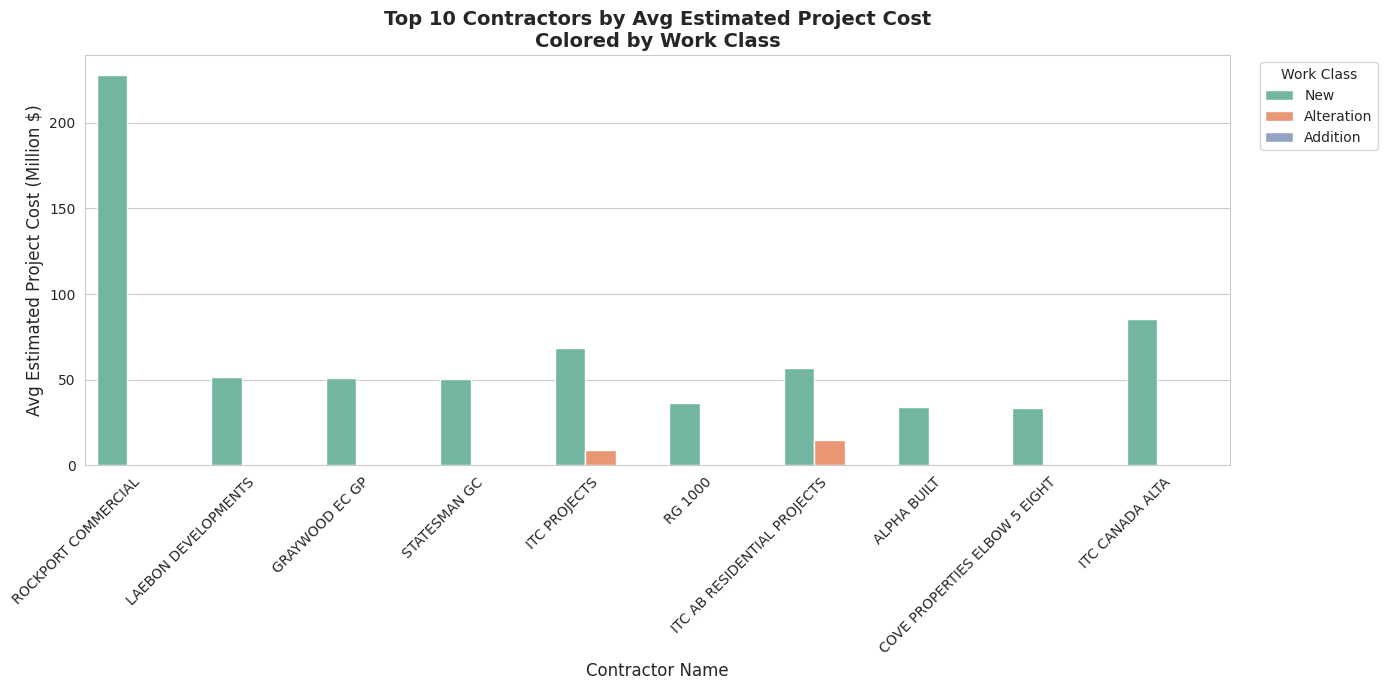

                      ContractorName   WorkClass  EstProjectCost  \
1052                     ALPHA BUILT         New    3.427910e+07   
3956   COVE PROPERTIES ELBOW 5 EIGHT         New    3.357884e+07   
6452                  GRAYWOOD EC GP         New    5.101148e+07   
7631     ITC AB RESIDENTIAL PROJECTS  Alteration    1.500263e+07   
7632     ITC AB RESIDENTIAL PROJECTS         New    5.671097e+07   
7633                 ITC CANADA ALTA    Addition    9.500000e+05   
7634                 ITC CANADA ALTA  Alteration    8.000000e+04   
7635                 ITC CANADA ALTA         New    8.531246e+07   
7636                    ITC PROJECTS  Alteration    8.800000e+06   
7637                    ITC PROJECTS         New    6.858196e+07   
8679             LAEBON DEVELOPMENTS         New    5.167236e+07   
12091                        RG 1000         New    3.641952e+07   
12320            ROCKPORT COMMERCIAL         New    2.280043e+08   
13526                   STATESMAN GC         New

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare top 10 contractors by mean project cost
top10_avg = (
    df.groupby(['ContractorName', 'WorkClass'])['EstProjectCost']
    .mean()
    .reset_index()
)

# Get top 10 contractor names
top10_contractors = (
    top10_avg.groupby('ContractorName')['EstProjectCost']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Filter top 10 contractors
top10_df = top10_avg[top10_avg['ContractorName'].isin(top10_contractors)].copy()

# Add cost in millions and round
top10_df['EstProjectCost_Million'] = (top10_df['EstProjectCost'] / 1e6).round(2)

# Sort contractors by cost
contractor_order = (
    top10_df.groupby('ContractorName')['EstProjectCost_Million']
    .mean()
    .sort_values(ascending=False)
    .index
)

# Plot
plt.figure(figsize=(14, 7))
sns.set_style("whitegrid")
sns.set_palette("Set2")

sns.barplot(
    data=top10_df,
    x='ContractorName',
    y='EstProjectCost_Million',
    hue='WorkClass',
    order=contractor_order
)

plt.ylabel('Avg Estimated Project Cost (Million $)', fontsize=12)
plt.xlabel('Contractor Name', fontsize=12)
plt.title('Top 10 Contractors by Avg Estimated Project Cost\nColored by Work Class', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Work Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()
print(top10_df)

### 💡 Insight: High-Value Construction Projects by Contractor

Several contractors are engaged in high-value construction projects, with estimated costs exceeding **\$50 million**.

- **ROCKPORT COMMERCIAL** tops the list with a project valued at **\$228 million**.
- Other major contributors include:
  - **ITC PROJECTS** – up to **\$68.58 million**
  - **ITC CANADA ALTA** – up to **\$85.31 million**
  - **GRAYWOOD EC GP** – **\$51.01 million**
  - **LAEBON DEVELOPMENTS** – **\$51.67 million**

The projects span various `WorkClass` types such as **New**, **Alteration**, and **Addition**, indicating a wide range of development activities.

### 📍 Interactive Bokeh Map with Dash

Developed an interactive dashboard using **Dash** and **Bokeh** to visualize the **estimated project cost** of building permits by **community** over different **years**.  

- A **dropdown menu** allows dynamic filtering by year.  
- **Bubble sizes** represent the magnitude of project costs for each community on a map.  

This visualization provides meaningful **spatial insights** into the **intensity and distribution** of development activity over time.


In [33]:
community_agg = df.groupby(['AppliedYear','CommunityCode', 'CommunityName']).agg({
    'EstProjectCost': 'sum',
    'Latitude': 'mean',
    'Longitude': 'mean',
    'PermitNum': 'count'
}).reset_index()

community_agg.rename(columns={'PermitNum': 'PermitCount'}, inplace=True)
community_agg


,AppliedYear,CommunityCode,CommunityName,EstProjectCost,Latitude,Longitude,PermitCount
0,1999,01C,RESIDUAL WARD 1 - CALGARY WEST,983000.0,51.087953,-114.235609,3
1,1999,02E,RESIDUAL WARD 2 - SUB AREA 2E,4000.0,51.157318,-114.210764,1
2,1999,13I,RESIDUAL WARD 13 - SUB AREA 13I,40000.0,50.889836,-114.105207,1
3,1999,ABB,ABBEYDALE,309731.0,51.060207,-113.929744,18
4,1999,ACA,ACADIA,1385912.0,50.973238,-114.059748,23
...,...,...,...,...,...,...,...
6803,2025,WND,WINDSOR PARK,2724988.0,51.005866,-114.078331,16
6804,2025,WOO,WOODLANDS,1391927.0,50.941760,-114.110539,23
6805,2025,WSP,WEST SPRINGS,42743619.0,51.058532,-114.202039,88
6806,2025,WWO,WOLF WILLOW,31237908.0,50.873413,-114.000345,137


In [34]:
app = dash.Dash(__name__)

def latlon_to_mercator(lat, lon):
    import math
    k = 6378137
    x = lon * (k * math.pi / 180.0)
    y = math.log(math.tan((90 + lat) * math.pi / 360.0)) * k
    return x, y

def create_bokeh_plot_html(year, data):
    df = data[data['AppliedYear'] == year].copy()
    if df.empty:
        return "<h3>No data for selected year.</h3>"

    mercator_coords = df.apply(lambda row: latlon_to_mercator(row['Latitude'], row['Longitude']), axis=1)
    df['mercator_x'] = [c[0] for c in mercator_coords]
    df['mercator_y'] = [c[1] for c in mercator_coords]

    min_radius = 5
    max_radius = 30
    cost_sqrt = np.sqrt(df['EstProjectCost'])
    min_cost_sqrt = cost_sqrt.min()
    max_cost_sqrt = cost_sqrt.max()
    df['radius'] = min_radius + (cost_sqrt - min_cost_sqrt) / (max_cost_sqrt - min_cost_sqrt) * (max_radius - min_radius)

    source = ColumnDataSource(df)

    color_mapper = LinearColorMapper(palette=Viridis256,
                                     low=df['EstProjectCost'].min(),
                                     high=df['EstProjectCost'].max())

    p = figure(
        x_axis_type="mercator", y_axis_type="mercator",
        title=f"Total Project Cost by Community in {year}",
        width=800, height=600,
        tools="pan,wheel_zoom,reset,hover,save"
    )

    from bokeh.models import WMTSTileSource
    osm_url = "https://tile.openstreetmap.org/{Z}/{X}/{Y}.png"
    p.add_tile(WMTSTileSource(url=osm_url))

    p.circle(
        x='mercator_x', y='mercator_y',
        size='radius',
        fill_color={'field': 'EstProjectCost', 'transform': color_mapper},
        fill_alpha=0.7,
        line_color=None,
        source=source
    )

    hover = p.select_one(HoverTool)
    hover.tooltips = [
        ("Community Code", "@CommunityCode"),
        ("Community Name", "@CommunityName"),
        ("Total Project Cost", "@EstProjectCost{$0,0}"),
        ("Permit Count", "@PermitCount")
    ]

    html = file_html(p, CDN, "Building Permits Map")
    return html


app.layout = html.Div([
    html.H2("Building Permits by Community with Year Filter"),

    dcc.Dropdown(
        id='year-dropdown',
        options=[{'label': str(y), 'value': y} for y in sorted(community_agg['AppliedYear'].unique())],
        value=community_agg['AppliedYear'].max(),
        clearable=False,
        style={'width': '200px'}
    ),

    html.Iframe(
        id='bokeh-iframe',
        style={'border': 'none', 'width': '820px', 'height': '650px'}
    )
])

@app.callback(
    Output('bokeh-iframe', 'srcDoc'),
    Input('year-dropdown', 'value')
)
def update_iframe(year):
    return create_bokeh_plot_html(year, community_agg)


if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>

## 🧠 4. Feature Engineering

#### 🔍 Exploring Unique Value Counts of Categorical Features


In [35]:
# Select categorical columns
categorical_cols = df.select_dtypes(include='object').columns

# Display unique value counts
unique_counts = df[categorical_cols].nunique().sort_values(ascending=False)

# Convert to DataFrame for better readability
unique_counts_df = unique_counts.reset_index()
unique_counts_df.columns = ['Feature', 'Unique_Count']

# Show the table
print(unique_counts_df)

              Feature  Unique_Count
0           PermitNum        436640
1   LocationAddresses        331356
2        LocationsWKT        326483
3    LocationsGeoJSON        323620
4     OriginalAddress        276749
5               Point        242780
6         Description         41816
7       ApplicantName         19235
8      ContractorName         10810
9       LocationTypes          1042
10        PermitClass           320
11      CommunityName           313
12      CommunityCode           312
13      StatusCurrent            22
14   PermitClassGroup            16
15          WorkClass             7
16         PermitType             4
17     WorkClassGroup             3
18  PermitClassMapped             3
19    WorkClassMapped             2
20   PermitTypeMapped             1


### 🎯 Categorical Feature Filtering and Grouping Logic

To prepare categorical variables for modeling, I have selected features with a **manageable number of unique values**—specifically those ranging from 10 to around 10,000.

In [36]:
# List of relevant categorical features with reasonable unique counts
key_categorical_features = [
    'ContractorName', 'LocationTypes', 'PermitClass', 'CommunityName', 'CommunityCode',
    'StatusCurrent', 'PermitClassGroup', 'WorkClass', 'PermitType',
    'WorkClassGroup', 'PermitClassMapped', 'WorkClassMapped'
]

# Display top 5 categories and counts for each
for feature in key_categorical_features:
    print(f"\nTop 5 values for '{feature}':")
    display(df[feature].value_counts().head(5))


Top 5 values for 'ContractorName':


,count
ContractorName,
JAYMAN BUILT,11764
SHANE HOMES,9140
MORRISON HOMES (CALGARY),8489
CEDARGLEN GROUP (THE),8323
CARDEL HOMES,7927



Top 5 values for 'LocationTypes':


,count
LocationTypes,
Titled Parcel,190036
Titled Parcel;Building,168816
Titled Parcel;Building;Building Suite,46348
Titled Parcel;Building;Entryway,6293
Titled Parcel;Building;Building Suite;Building Suite,3395



Top 5 values for 'PermitClass':


,count
PermitClass,
1106 - Single Family House,126035
1101 - Basement Development,57650
1301 - Private Detached Garage,57535
1101 - Improvements (Single Family),23858
3402 - Office,20682



Top 5 values for 'CommunityName':


,count
CommunityName,
DOWNTOWN COMMERCIAL CORE,13911
SADDLE RIDGE,10515
CRANSTON,10384
PANORAMA HILLS,9989
TUSCANY,9354



Top 5 values for 'CommunityCode':


,count
CommunityCode,
DNC,13911
SAD,10515
CRA,10384
PAN,9989
TUS,9354



Top 5 values for 'StatusCurrent':


,count
StatusCurrent,
Completed,404715
Issued Permit,13057
Expired,5923
File Closed,4267
Pre Backfill Phase,3724



Top 5 values for 'PermitClassGroup':


,count
PermitClassGroup,
Single Family,242560
Garage,58242
Commercial,56479
Two Family,25356
Secondary Suites,14366



Top 5 values for 'WorkClass':


,count
WorkClass,
New,225834
Alteration,186171
Addition,16362
Repair,5013
Fire/ Security Alarm,2035



Top 5 values for 'PermitType':


,count
PermitType,
Residential Improvement Project,199134
Single Construction Permit,146815
Commercial / Multi Family Project,90090
Environmental Restoration Permit,601



Top 5 values for 'WorkClassGroup':


,count
WorkClassGroup,
New,225834
Improvement,207549
Unspecified,3257



Top 5 values for 'PermitClassMapped':


,count
PermitClassMapped,
Residential,360510
Non-Residential,76026
Unspecified,104



Top 5 values for 'WorkClassMapped':


,count
WorkClassMapped,
New,225834
Existing,207549




*   LocationTypes is excluded due to its complex, multi-level format requiring extensive preprocessing not suitable for current analysis scope.
*  Excluded high-cardinality and geospatial columns (e.g., PermitNum, LocationAddresses, LocationsWKT) as they act as identifiers or require advanced preprocessing.
*  Included categorical variables like PermitClass, CommunityName, StatusCurrent, and WorkClassGroup for ANOVA and grouping after applying top-N filtering where needed.
* Excluded low-variance columns like PermitTypeMapped with only one unique value, which do not contribute meaningfully to analysis.



### 🔄 Encoding Top N Categories with 'Other'

To reduce dimensionality and focus on the most frequent categories, we group the top 10 categories for selected features and label the rest as `"Other"`:

- `CommunityName → CommunityName_Top`
- `StatusCurrent → StatusCurrent_Top`
- `ContractorName → ContractorName_Top`
- `PermitClass` → `PermitClass_Top`

This helps improve model performance and reduces noise from infrequent categories.



In [37]:
import pandas as pd

# Define N for top categories
top_n = 10

# Group top N categories for CommunityName
top_community = df['CommunityName'].value_counts().nlargest(top_n).index
df['CommunityName_Top'] = df['CommunityName'].apply(lambda x: x if x in top_community else 'Other')

# Group top N categories for StatusCurrent
top_status = df['StatusCurrent'].value_counts().nlargest(top_n).index
df['StatusCurrent_Top'] = df['StatusCurrent'].apply(lambda x: x if x in top_status else 'Other')

#  Group Top N Contractors by frequency
top_contractors = df['ContractorName'].value_counts().nlargest(top_n).index
df['ContractorName_Top'] = df['ContractorName'].apply(lambda x: x if x in top_contractors else 'Other')


# Group Top N Contractors by frequency
top_PermitClass = df['PermitClass'].value_counts().nlargest(10).index
df['PermitClass_Top'] = df['PermitClass'].apply(lambda x: x if x in top_PermitClass else 'Other')
# Verify transformations
print(df['CommunityName_Top'].value_counts())
print(df['StatusCurrent_Top'].value_counts())
print(df['ContractorName_Top'].value_counts())
print(df['PermitClass_Top'] .value_counts())

/tmp/ipython-input-1833562022.py:43: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.



CommunityName_Top
Other                       338439
DOWNTOWN COMMERCIAL CORE     13911
SADDLE RIDGE                 10515
CRANSTON                     10384
PANORAMA HILLS                9989
TUSCANY                       9354
EVANSTON                      9238
EVERGREEN                     9182
MCKENZIE TOWNE                9021
MAHOGANY                      8818
COVENTRY HILLS                7789
Name: count, dtype: int64
StatusCurrent_Top
Completed                          404715
Issued Permit                       13057
Expired                              5923
File Closed                          4267
Pre Backfill Phase                   3724
Hold                                 1572
Other                                1179
Pending Plans Review Assignment       781
In Review                             571
Pre Board Phase                       427
New                                   424
Name: count, dtype: int64
ContractorName_Top
Other                               359662
JAY

### ✅ Categorical vs. Target Correlation Using ANOVA

- **Why ANOVA?**
  - Suitable for assessing if different categories of a feature have significantly different mean values of a continuous target (`LogEstProjectCost`).
  - Useful for identifying **informative categorical features** before encoding and modeling.
- **Interpretation**:
  - **Low p-value** ⇒ Strong relationship with target.
  - **Use top features** for further encoding and modeling.

In [38]:
# ✅ Useful categorical features to test
useful_categoricals = [
    'ContractorName_Top', 'CommunityName_Top', 'StatusCurrent_Top',
    'PermitClass_Top', 'PermitClassGroup', 'WorkClass',
    'PermitType', 'WorkClassGroup', 'WorkClassMapped'
]

# ✅ Function to perform ANOVA for a single categorical feature
def perform_anova(df, feature, target='LogEstProjectCost'):
    groups = [g[target].dropna() for _, g in df.groupby(feature)]
    if len(groups) > 1:
        f_stat, p_val = stats.f_oneway(*groups)
        return {'Feature': feature, 'F-statistic': f_stat, 'p-value': p_val}
    return {'Feature': feature, 'F-statistic': None, 'p-value': None}

# ✅ Apply ANOVA to each categorical feature
anova_results = [perform_anova(df, col) for col in useful_categoricals]

# ✅ Convert to DataFrame and sort by p-value (asc) and F-statistic (desc)
anova_df = pd.DataFrame(anova_results).sort_values(
    by=['p-value', 'F-statistic'], ascending=[True, False]
)

# ✅ Print results and ranked feature list
print(anova_df)
ranked_features = list(anova_df['Feature'])
print(ranked_features)


              Feature    F-statistic  p-value
8     WorkClassMapped  134344.056213      0.0
6          PermitType  123716.577094      0.0
7      WorkClassGroup   69627.498739      0.0
3     PermitClass_Top   37864.173973      0.0
5           WorkClass   23750.270129      0.0
0  ContractorName_Top    5640.866564      0.0
4    PermitClassGroup    2859.285210      0.0
2   StatusCurrent_Top     692.840814      0.0
1   CommunityName_Top     556.782793      0.0
['WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'StatusCurrent_Top', 'CommunityName_Top']


All tested categorical features significantly influence the estimated project cost, with `WorkClassMapped`, `PermitType`, and `WorkClassGroup` showing the strongest effects based on high F-statistics and near-zero p-values.


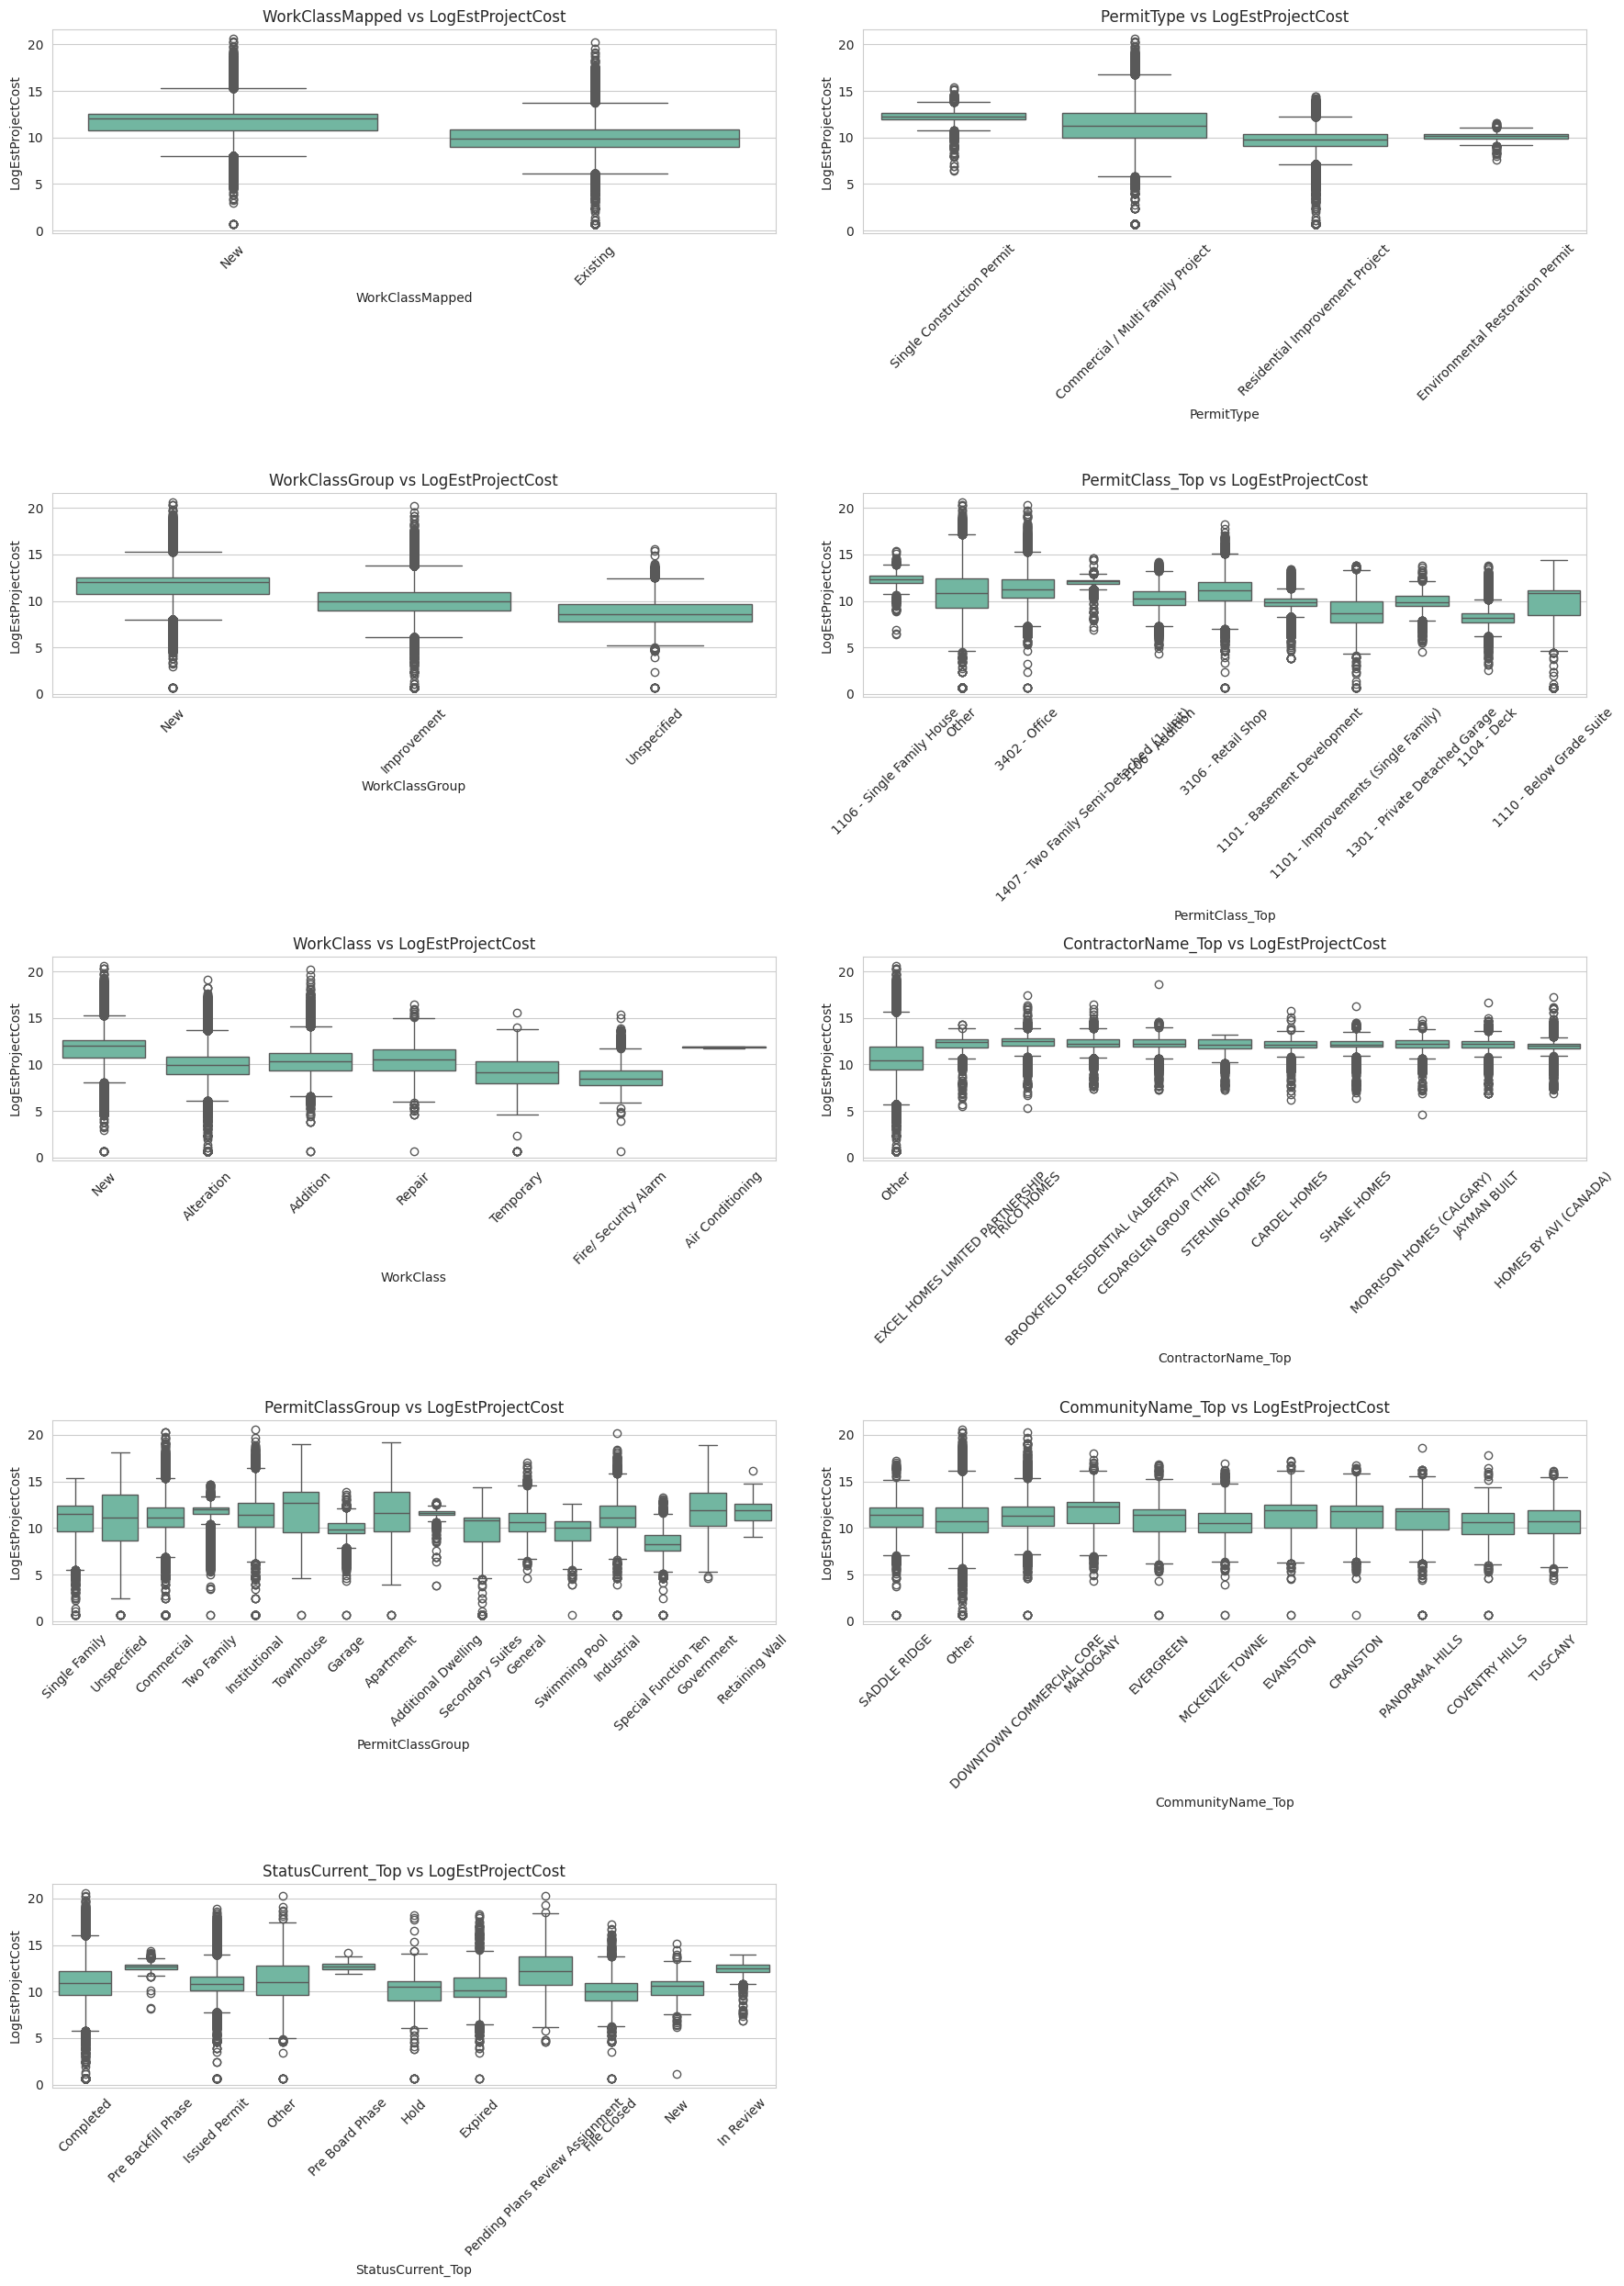

In [39]:

top_features = [
'WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top', 'StatusCurrent_Top'
]
n_rows = 5
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 25))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.boxplot(data=df, x=feature, y='LogEstProjectCost', ax=axes[i])
    axes[i].set_title(f'{feature} vs LogEstProjectCost', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(len(top_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [40]:
df[top_features].isnull().sum()

,0
WorkClassMapped,3257
PermitType,0
WorkClassGroup,0
PermitClass_Top,0
WorkClass,0
ContractorName_Top,0
PermitClassGroup,0
CommunityName_Top,0
StatusCurrent_Top,0


### 🧹 Imputing missing values in 'WorkClassMapped'

In [41]:
df['WorkClassMapped'] = np.where(
    df['WorkClassGroup'] == 'New', 'New',
    np.where(
        df['WorkClassGroup'] == 'Improvement', 'Existing',
        'Unspecified'
    )
)

### 📊 Correlation Analysis with Target Variable

Computed the Pearson correlation between numerical features and the log-transformed estimated project cost (`LogEstProjectCost`). This helps identify which numeric variables have the strongest linear relationships with the target, guiding feature selection and engineering.



In [42]:
# Select numerical features including target
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Display correlation of features with target variable
target_corr = corr_matrix['LogEstProjectCost'].sort_values(ascending=False)
print(target_corr)


LogEstProjectCost     1.000000
TotalSqFt             0.738000
ApprovalDuration      0.228705
CompletionDuration    0.201633
HousingUnits          0.191535
EstProjectCost        0.176495
LocationCount         0.077336
AppliedYear           0.072516
Longitude             0.002618
Latitude             -0.003392
Name: LogEstProjectCost, dtype: float64


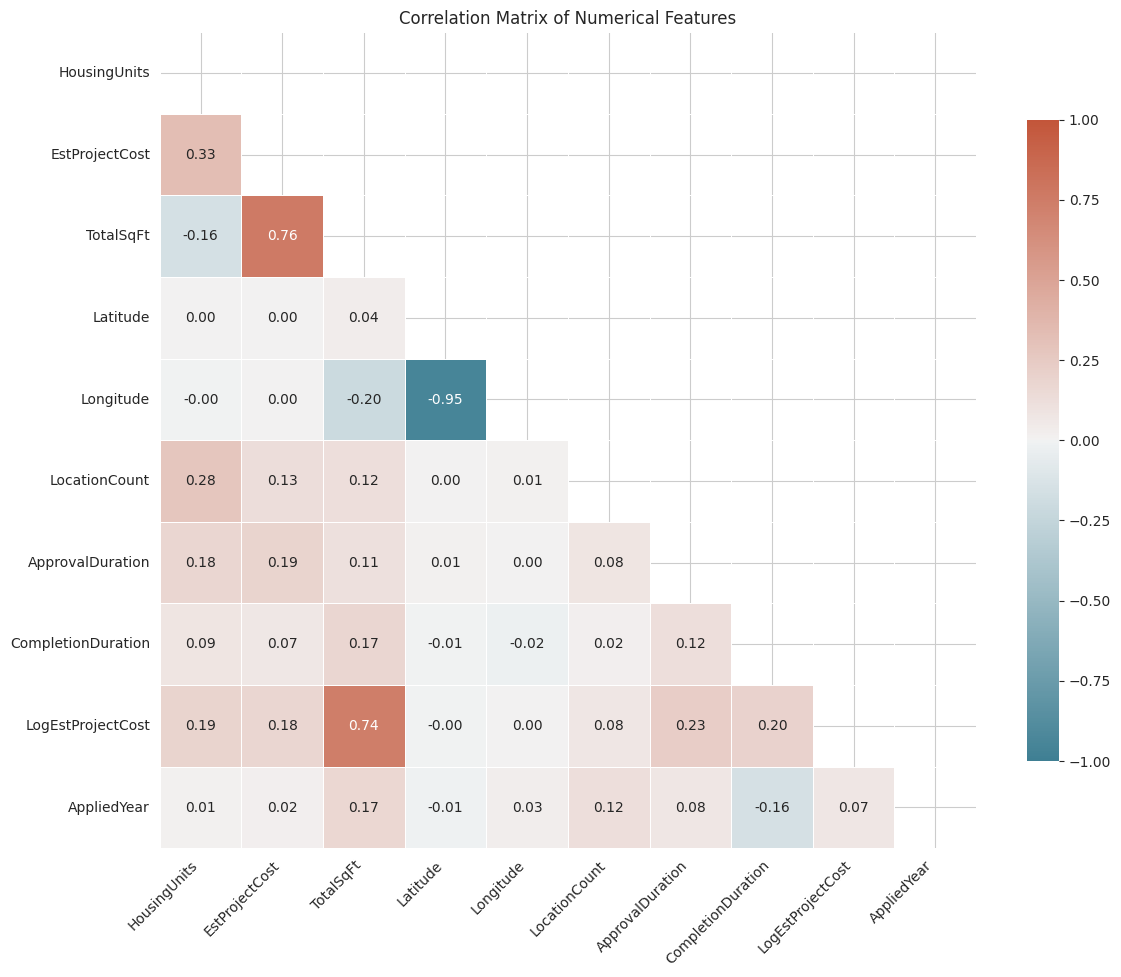

In [43]:
# Step 1: Select numeric columns
numeric_df = df.select_dtypes(include=['float64', 'int64', 'int32'])

# Step 2: Compute the correlation matrix
corr = numeric_df.corr()

# Step 3: Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Step 4: Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Step 5: Define a diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Step 6: Draw the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75},
    vmin=-1,
    vmax=1
)

# Step 7: Add title and layout
plt.title("Correlation Matrix of Numerical Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**Based on correlation and redundancy:**

Include:

TotalSqFt → strong predictive power

ApprovalDuration, CompletionDuration → moderate value

HousingUnits → optional, check multicollinearity first

Exclude:

EstProjectCost → this is directly related to the target (log-transformed), would leak target info

Latitude, Longitude, LocationCount, Year → very weak or no correlation

### 🔍 Checking missing values in numeric columns


In [44]:
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32'])
missing_numeric = numeric_cols.isnull().sum()
missing_numeric = missing_numeric[missing_numeric > 0].sort_values(ascending=False)
print(missing_numeric)

TotalSqFt             289825
CompletionDuration     21905
ApprovalDuration        4409
LocationCount             14
dtype: int64


### ✅ Filter records with valid duration values
Ensure 'ApprovalDuration' is within 0–365 days and 'CompletionDuration' within 0–1000 days.
This step removes outliers or incorrect data entries that may skew model performance.

Count valid entries for each duration field separately and together

In [45]:
# Check how many rows have valid (non-negative, reasonable) durations

# ApprovalDuration: 0 to 365 days
valid_approval = df[(df['ApprovalDuration'] >= 0) & (df['ApprovalDuration'] <= 365)]
print(f"Valid ApprovalDuration records: {len(valid_approval)}")

# CompletionDuration: 0 to 1000 days
valid_completion = df[(df['CompletionDuration'] >= 0) & (df['CompletionDuration'] <= 1000)]
print(f"Valid CompletionDuration records: {len(valid_completion)}")

# check how many records satisfy both conditions
valid_both = df[
    (df['ApprovalDuration'] >= 0) & (df['ApprovalDuration'] <= 365) &
    (df['CompletionDuration'] >= 0) & (df['CompletionDuration'] <= 1000)
]
print(f"Records with both durations valid: {len(valid_both)}")
# Keep only rows with valid ApprovalDuration and CompletionDuration
df = df[
    (df['ApprovalDuration'] >= 0) & (df['ApprovalDuration'] <= 365) &
    (df['CompletionDuration'] >= 0) & (df['CompletionDuration'] <= 1000)
]

# Optional: Print updated shape
print(f"Remaining records after filtering: {df.shape[0]}")


Valid ApprovalDuration records: 431032
Valid CompletionDuration records: 399600
Records with both durations valid: 398721
Remaining records after filtering: 398721


### Remove Rows where HousingUnits is less than 0

In [46]:
df=df[df['HousingUnits']>=0]

### 🧹 Imputing missing values in 'ApprovalDuration' and 'CompletionDuration'
 For records with missing 'ApprovalDuration' and 'CompletionDuration', fill using the median value
 grouped by 'PermitClassGroup' and 'WorkClassGroup' to preserve contextual accuracy.


In [47]:
# Impute ApprovalDuration
df['ApprovalDuration'] = df.groupby(['PermitClassGroup', 'WorkClassGroup'])['ApprovalDuration'].transform(
    lambda x: x.fillna(x.median())
)

In [48]:
# Impute CompletionDuration
df['CompletionDuration'] = df.groupby(['PermitClassGroup', 'WorkClassGroup'])['CompletionDuration'].transform(
    lambda x: x.fillna(x.median())
)

In [49]:
# ✅ Correlation analysis for numeric predictors
# Check Pearson correlation between TotalSqFt and other numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('TotalSqFt', errors='ignore')
correlations = df[numeric_cols].corrwith(df['TotalSqFt']).sort_values(ascending=False)

print("📊 Correlation with TotalSqFt:")
print(correlations)


📊 Correlation with TotalSqFt:
EstProjectCost        0.762186
LogEstProjectCost     0.747324
CompletionDuration    0.184064
LocationCount         0.142813
ApprovalDuration      0.094926
Latitude              0.040499
HousingUnits         -0.150263
Longitude            -0.196925
dtype: float64


### Imputing Missing Values in `TotalSqFt` Using Group-Based Median

To handle missing values in the `TotalSqFt` column, apply a group-wise median imputation strategy based on two relevant features: `PermitClassGroup` and `CompletionDuration`. This approach assumes that the combination of permit class and duration is a strong indicator of expected square footage.





In [50]:
# Step 1: Create combined key
df['GroupKey'] = df['PermitClassGroup'].astype(str) + "_" + df['CompletionDuration'].astype(str)

# Step 2: Median per combined group
median_sqft_per_combo = df[~df['TotalSqFt'].isnull()].groupby('GroupKey')['TotalSqFt'].median()

# Step 3: Impute using the combo
def impute_totalsqft(row):
    if pd.isnull(row['TotalSqFt']) and pd.notnull(row['PermitClassGroup']) and pd.notnull(row['CompletionDuration']):
        key = str(row['PermitClassGroup']) + "_" + str(row['CompletionDuration'])
        return median_sqft_per_combo.get(key, np.nan)
    else:
        return row['TotalSqFt']

# Step 4: Apply
df['TotalSqFt'] = df.apply(impute_totalsqft, axis=1)
df.drop(columns='GroupKey', inplace=True)

# Step 5: Report
print("Missing TotalSqFt after combined group imputation:", df['TotalSqFt'].isnull().sum())


Missing TotalSqFt after combined group imputation: 190985


### Further Imputing `TotalSqFt` Using `PermitClassGroup` Median

After imputing based on the combined `PermitClassGroup` and `CompletionDuration`, some `TotalSqFt` values may still be missing.  
To further reduce missing data, we impute the remaining null values using the median `TotalSqFt` within each `PermitClassGroup`.

This step ensures that even if the combined group data was insufficient, we still leverage domain-specific grouping to estimate reasonable values.


In [51]:
#Step 1: Calculate median TotalSqFt per PermitClassGroup(exclude missing TotalSqFt)
median_sqft_per_group = df.groupby('PermitClassGroup')['TotalSqFt'].median()

# Step 2: Define function to impute TotalSqFt per row
def impute_totalsqft(row):
    if pd.isnull(row['TotalSqFt']) and pd.notnull(row['PermitClassGroup']):
        # Use group's median if available, else NaN
        return median_sqft_per_group.get(row['PermitClassGroup'], np.nan)
    else:
        return row['TotalSqFt']

# Step 3: Apply function row-wise
df['TotalSqFt'] = df.apply(impute_totalsqft, axis=1)

# Step 4 (optional): Check how many values are still missing after imputation
print("Missing TotalSqFt after group median imputation:", df['TotalSqFt'].isnull().sum())

Missing TotalSqFt after group median imputation: 148370


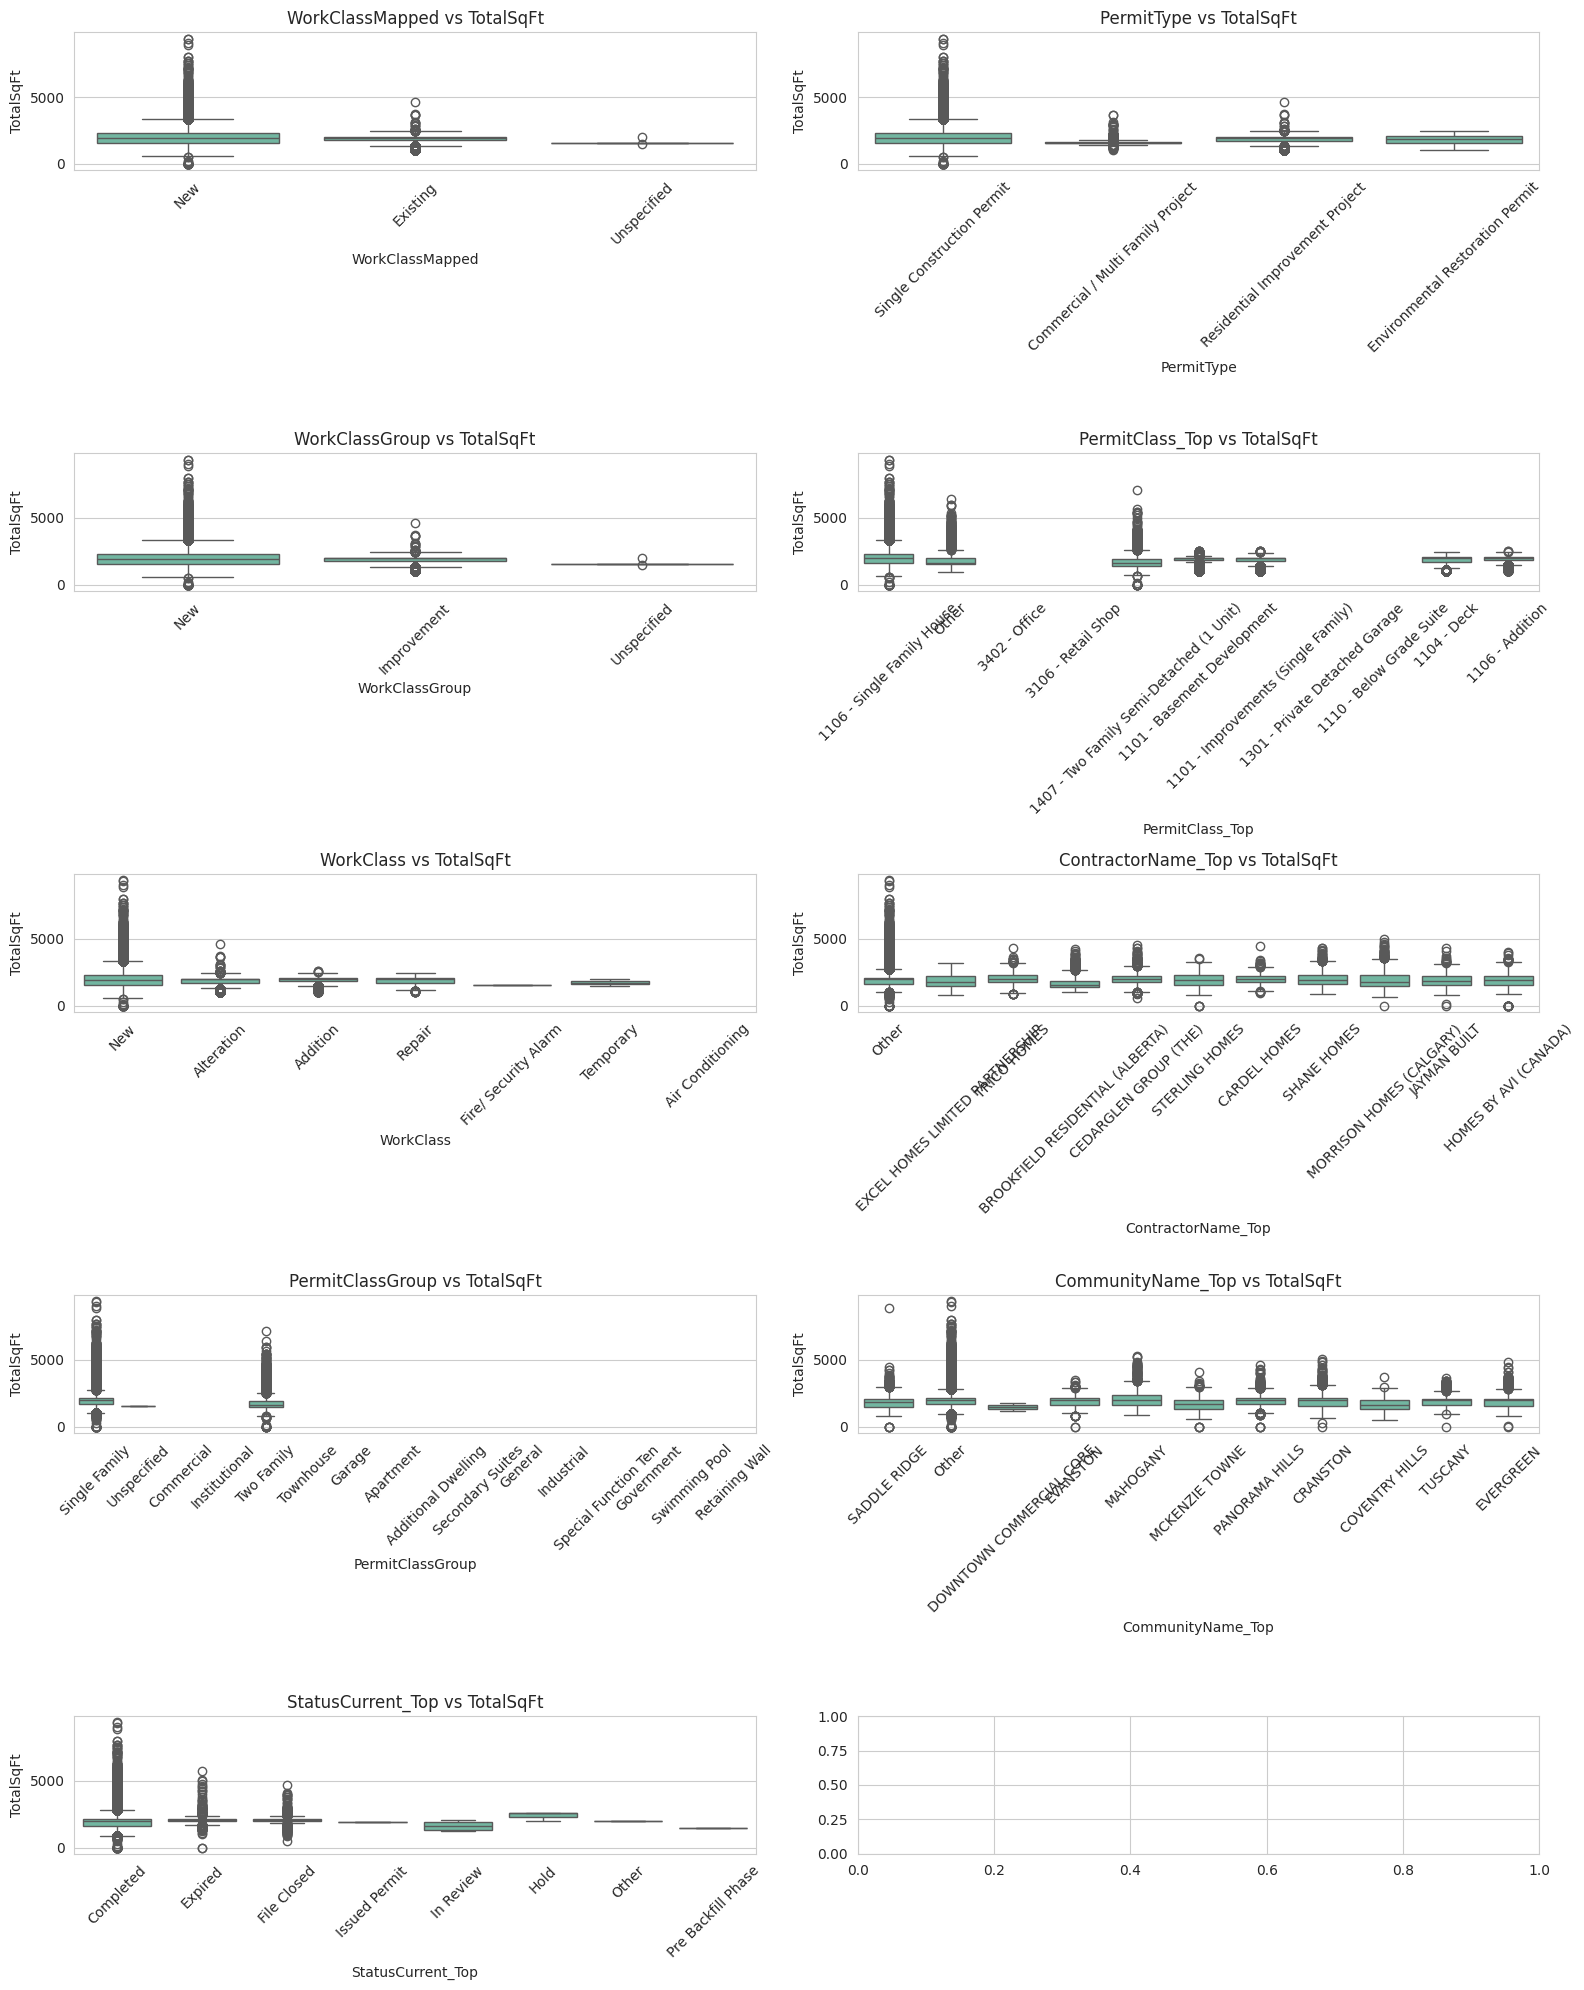

In [52]:
top_features = [
'WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top', 'StatusCurrent_Top'
]

n_rows = 5
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 20))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    sns.boxplot(data=df, x=feature, y='TotalSqFt', ax=axes[i])
    axes[i].set_title(f'{feature} vs TotalSqFt', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 🧠 Imputing Missing Values in `TotalSqFt` Using  HistGradientBoostingRegressor

This notebook outlines the step-by-step procedure to impute missing values in the `TotalSqFt` column using a machine learning pipeline with a `HistGradientBoostingRegressor`.

In [53]:
# Separate known/missing rows for TotalSqFt
df_known = df[df['TotalSqFt'].notnull()].copy()
df_missing = df[df['TotalSqFt'].isnull()].copy()

# Selected feature columns
features = [
    'ApprovalDuration', 'CompletionDuration', 'HousingUnits',
    'WorkClassMapped', 'PermitType', 'WorkClassGroup',
    'PermitClass_Top', 'WorkClass', 'ContractorName_Top',
    'PermitClassGroup', 'CommunityName_Top', 'StatusCurrent_Top',
    'AppliedYear', 'LocationCount'
]

# Split features into numeric and categorical
numeric_features = ['ApprovalDuration', 'CompletionDuration', 'HousingUnits', 'AppliedYear', 'LocationCount']
categorical_features = [col for col in features if col not in numeric_features]

# Preprocessing transformers
numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# HistGradientBoostingRegressor pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(
        max_iter=100,       # Increase if needed for accuracy
        learning_rate=0.1,
        max_depth=10,
        l2_regularization=0.1,
        early_stopping=True,
        random_state=42
    ))
])

# Fit model
X_train = df_known[features]
y_train = df_known['TotalSqFt']
pipeline.fit(X_train, y_train)

# Predict and impute missing values
X_missing = df_missing[features]
df.loc[df['TotalSqFt'].isnull(), 'TotalSqFt'] = pipeline.predict(X_missing)

# Final check
print("✅ Remaining missing values in TotalSqFt:", df['TotalSqFt'].isnull().sum())


✅ Remaining missing values in TotalSqFt: 0


### 🔧 Feature Engineering: Creating Derived Metrics

In this step, the dataset is enhanced by introducing two new engineered features:

- **SqFtPerUnit**: Represents the average square footage per housing unit, helping normalize building size by number of units.

These derived feature aim to improve model performance by adding normalized and interpretable metrics based on existing columns.


In [54]:
# ✅ Feature Engineering: Creating Derived Metrics

# Handle division by zero by replacing zero HousingUnits with NaN, then fill with 0 after division
df['SqFtPerUnit'] = df['TotalSqFt'] / df['HousingUnits'].replace({0: np.nan})
df['SqFtPerUnit'] = df['SqFtPerUnit'].fillna(0)

"# Handle division by zero for ApprovalDuration\ndf['BuildDurationRatio'] = df['CompletionDuration'] / df['ApprovalDuration'].replace({0: np.nan})\ndf['BuildDurationRatio'] = df['BuildDurationRatio'].fillna(0)\n# Split into code and description\ndf[['PermitCode', 'PermitDetails']] = df['PermitClass'].str.split(' - ', n=1, expand=True)\n\n# Remove any non-digit characters from PermitCode\ndf['PermitCode'] = df['PermitCode'].str.extract('(\\d+)')\n\n# Preview\nprint(df[['PermitCode', 'PermitDetails']])\ndf['PermitCode'] = df['PermitCode'].astype(str)"

## 🧠 Model Training & Evaluation

In this step, we train a regression model to predict the **log-transformed Estimated Project Cost** (`LogEstProjectCost`) using selected engineered features and categorical/numerical variables.

### 🔍 Step-by-Step Modeling Summary using RandomForestRegressor

1. **Feature Selection**: Defined the input features (`model_features`) and target (`LogEstProjectCost`).
2. **Train-Test Split**: Divided the dataset into 80% training and 20% testing sets.
3. **Preprocessing Pipeline**:
   - Scaled numerical features using `StandardScaler`.
   - Encoded categorical features using `OneHotEncoder`.
4. **Model Pipeline**:
   - Combined preprocessing and a `RandomForestRegressor` into a `Pipeline`.
   - Used `max_depth=7` to control overfitting and `n_estimators=100` for speed.
5. **Model Training**: Trained the pipeline on the training set.
6. **Evaluation**:
   - Predicted values on the test set.
   - Evaluated the model using Root Mean Squared Error (RMSE) and R² Score.

---

### 📈 Results (on `LogEstProjectCost`):

- **RMSE**: `0.928`
- **R² Score**: `0.717`



In [55]:
# Step 0: Define features and target
model_features = ['TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits','AppliedYear','LocationCount','SqFtPerUnit',
            'WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top',
                  'StatusCurrent_Top']

target = 'LogEstProjectCost'

X = df[model_features]
y = df[target]

# Identify feature types
categorical = ['WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top', 'StatusCurrent_Top']
numerical = [ 'TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits','AppliedYear','LocationCount','SqFtPerUnit']

# Step 1: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Build Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
    ]
)

# Step 3: Build Model Pipeline
model_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=7,         # Control complexity
        n_jobs=-1,           # Use all CPU cores
        random_state=42
    ))
])

# Step 4: Train model
model_pipeline.fit(X_train, y_train)
# Step 5: Predict and evaluate
y_pred = model_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # square root of MSE
r2 = r2_score(y_test, y_pred)

print("✅ Model Evaluation:")
print("RMSE:", round(rmse, 4))
print("R² Score:", round(r2, 4))
# Reverse log-transform
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred)

# Evaluation in original cost scale
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2_actual = r2_score(y_test_actual, y_pred_actual)

print("Real-world RMSE:", round(rmse_actual, 2))
print("Real-world R² Score:", round(r2_actual, 4))


✅ Model Evaluation:
RMSE: 0.9287
R² Score: 0.7178
Real-world RMSE: 1233514.57
Real-world R² Score: 0.2959


### 🔧 Model Building, Training, and Evaluation (XGBoost)

#### 🛠️ Model Pipeline Construction
Created a machine learning pipeline using `Pipeline()` from `sklearn.pipeline`. This pipeline encapsulates both preprocessing and modeling steps in one streamlined process.

- **Preprocessing Step**: Uses the pre-built `preprocessor` which handles numerical scaling and categorical encoding.
- **Modeling Step**: Implements `XGBRegressor`, a powerful gradient boosting algorithm known for handling non-linear relationships and feature interactions effectively.
---
### 📈 Results (on `LogEstProjectCost`):

- **RMSE**: `0.8537`
- **R² Score**: `0.7616`


In [56]:
model_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])
# Train model
model_pipeline.fit(X_train, y_train)
# Predict and evaluate
y_pred = model_pipeline.predict(X_test)

y_pred = model_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # square root of MSE
r2 = r2_score(y_test, y_pred)

print("✅ Model Evaluation:")
print("RMSE:", round(rmse, 4))
print("R² Score:", round(r2, 4))
# Reverse log-transform
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred)

# Evaluation in original cost scale
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2_actual = r2_score(y_test_actual, y_pred_actual)

print("Real-world RMSE:", round(rmse_actual, 2))
print("Real-world R² Score:", round(r2_actual, 4))

✅ Model Evaluation:
RMSE: 0.8537
R² Score: 0.7616
Real-world RMSE: 1054472.19
Real-world R² Score: 0.4855


## 📌 Step-by-Step: Outlier Removal and Model Improvement (RandomForest and XGBoost Regression)


###🔹 Step 1: Understand the Target Variable Distribution
Explore the distribution of `EstProjectCost` and `LogEstProjectCost`

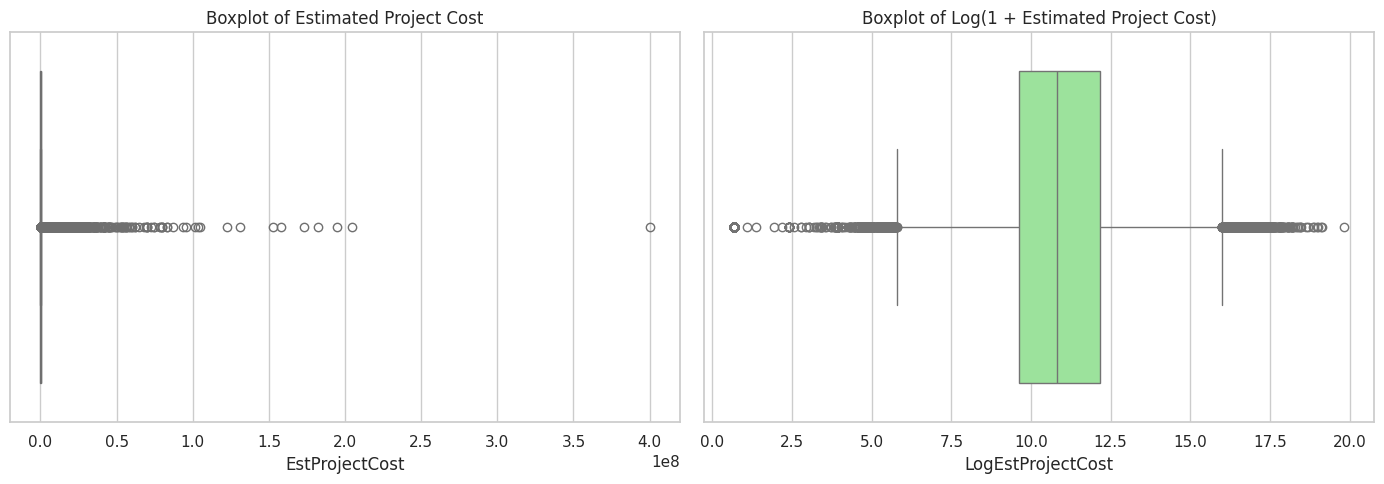

In [57]:
# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Boxplot for original Estimated Project Cost
sns.boxplot(x=df['EstProjectCost'], ax=axes[0], color="skyblue")
axes[0].set_title("Boxplot of Estimated Project Cost")
axes[0].set_xlabel("EstProjectCost")

# Boxplot for log-transformed Estimated Project Cost
sns.boxplot(x=df['LogEstProjectCost'], ax=axes[1], color="lightgreen")
axes[1].set_title("Boxplot of Log(1 + Estimated Project Cost)")
axes[1].set_xlabel("LogEstProjectCost")

# Show plots
plt.tight_layout()
plt.show()

### 🔹 Step 2: Detect Outliers Using the IQR Method
Apply the Interquartile Range (IQR) technique to identify outliers.

In [58]:
Q1 = df['EstProjectCost'].quantile(0.25)
Q3 = df['EstProjectCost'].quantile(0.75)
IQR = Q3 - Q1

# Outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")


Lower bound: -251515.5, Upper bound: 459192.5


###🔹 Step 3: Remove Outliers
Filter out rows where the target variable lies outside the IQR boundary

Original rows: 398719, After removing outliers: 378303


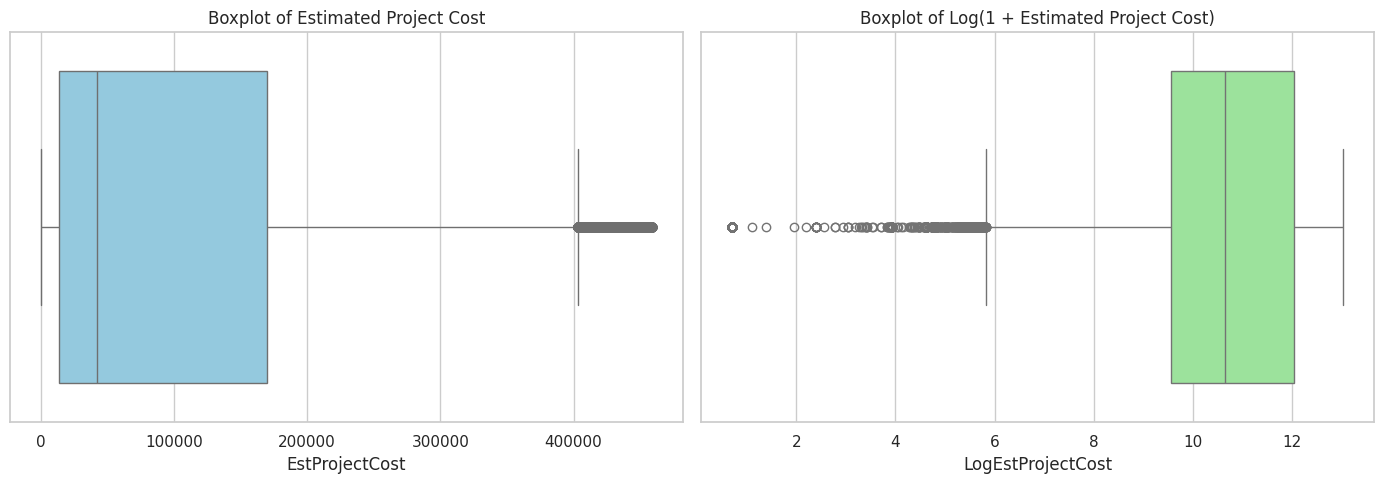

In [59]:
df_filtered = df[(df['EstProjectCost'] >= lower_bound) & (df['EstProjectCost'] <= upper_bound)]

print(f"Original rows: {len(df)}, After removing outliers: {len(df_filtered)}")
# Set plot style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Boxplot for original Estimated Project Cost
sns.boxplot(x=df_filtered['EstProjectCost'], ax=axes[0], color="skyblue")
axes[0].set_title("Boxplot of Estimated Project Cost")
axes[0].set_xlabel("EstProjectCost")

# Boxplot for log-transformed Estimated Project Cost
sns.boxplot(x=df_filtered['LogEstProjectCost'], ax=axes[1], color="lightgreen")
axes[1].set_title("Boxplot of Log(1 + Estimated Project Cost)")
axes[1].set_xlabel("LogEstProjectCost")

# Show plots
plt.tight_layout()
plt.show()


###🔹 Step 4: Model Training, Prediction, and Evaluation

In this step, four different regression models applied on the filtered dataset to predict the logarithm of the estimated project cost (`LogEstProjectCost`). The models used are:

- **Random Forest Regressor**
- **XGBoost Regressor**
- **LightGBM Regressor**
- **CatBoost Regressor**

This approach provides a fair comparison across multiple advanced gradient boosting and ensemble techniques, aiding in selection of the most effective model for estimating project costs.

In [60]:
# =================== Feature Preparation ===================
model_features = ['TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits','AppliedYear','LocationCount','SqFtPerUnit',
            'WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top',
                  'StatusCurrent_Top']
target = 'LogEstProjectCost'

# Split features and target
X = df_filtered[model_features]
y = df_filtered[target]
y_original = np.expm1(y)  # original scale

# Categorical and numerical features
categorical = ['WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top', 'StatusCurrent_Top']
numerical = ['TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits','AppliedYear','LocationCount','SqFtPerUnit']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
])

# =================== Model Definitions ===================
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, force_row_wise=True, feature_name='auto'),
    "CatBoost": CatBoostRegressor(n_estimators=100, learning_rate=0.1, depth=6, random_state=42, verbose=0)
}

results = []

# =================== Training, Predicting, Evaluating ===================
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocess', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_train, y_train)

    # Predict in log scale
    y_pred_log = pipeline.predict(X_test)

    # Convert to original scale
    y_pred_original = np.expm1(y_pred_log)
    y_test_original = np.expm1(y_test)

    # Evaluate
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    r2_log = r2_score(y_test, y_pred_log)

    rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2_orig = r2_score(y_test_original, y_pred_original)

    results.append({
        'Model': name,
        'RMSE (Log)': round(rmse_log, 4),
        'R² (Log)': round(r2_log, 4),
        'RMSE (Original)': round(rmse_orig, 2),
        'R² (Original)': round(r2_orig, 4)
    })

# =================== Results Table ===================
results_df = pd.DataFrame(results).sort_values(by='R² (Original)', ascending=False)
print("📊 Model Performance Comparison:\n")
print(results_df.to_string(index=False))


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2137: UserWarning:

feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.



[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Warning] Unknown parameter: feature_name
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 302642, number of used features: 76
[LightGBM] [Info] Start training from score 10.626419
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMRegressor was fitted with feature names



[LightGBM] [Warning] Unknown parameter: feature_name
📊 Model Performance Comparison:

        Model  RMSE (Log)  R² (Log)  RMSE (Original)  R² (Original)
      XGBoost      0.8124    0.7509         46871.54         0.8387
     LightGBM      0.8153    0.7492         47052.44         0.8375
Random Forest      0.8246    0.7434         47632.99         0.8334
     CatBoost      0.8246    0.7434         48286.65         0.8288


In [61]:
results_df.to_csv('model_performance.csv', index=False)

###🔹 Step 5: Applied XGBRegressor
Model Evaluation Summary (Test Data):
---
Log Scale ---
- RMSE (log): 0.8055
- R² Score (log): 0.7551

Original Scale ---
- RMSE:46193.53
- R² Score: 0.8434

In [62]:
# Step 0: Define features and target
model_features = ['TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits','AppliedYear','LocationCount','SqFtPerUnit',
            'WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top',
                  'StatusCurrent_Top']

target = 'LogEstProjectCost'

# Use filtered data
X = df_filtered[model_features]
y = df_filtered[target]
# Identify feature types
categorical = ['WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top', 'StatusCurrent_Top']
numerical = [ 'TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits','AppliedYear','LocationCount','SqFtPerUnit']

# Step 1: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Build Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
    ]
)
model_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])
# Step 4: Train model
model_pipeline.fit(X_train, y_train)

# ✅ Step 5: Predict and Evaluate (Log Scale)
y_pred_log = model_pipeline.predict(X_test)

# Step 6: Extract feature names after preprocessing
# This is needed because OneHotEncoder expands categorical features
onehot = model_pipeline.named_steps['preprocess'].named_transformers_['cat']
onehot_feature_names = onehot.get_feature_names_out(categorical)

all_feature_names = numerical + list(onehot_feature_names)

# Step 7: Extract feature importances from XGBoost
xgb_model = model_pipeline.named_steps['model']
importances = xgb_model.feature_importances_

# Create a DataFrame for easy visualization and saving
feat_imp_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 10 (optional)
print("\n🔍 Top 10 Important Features:")
print(feat_imp_df.head(10))

# Step 8: Save to CSV
feat_imp_df.to_csv("xgb_feature_importance.csv", index=False)
print("\n✅ Feature importance saved to 'xgb_feature_importance.csv'")


# Log-scale metrics
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)

# ✅ Convert back to original EstProjectCost scale
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Original-scale metrics
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2_original = r2_score(y_test_original, y_pred_original)

# 📊 Print Results
print("Model Evaluation Summary:")
print("--- Log Scale ---")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² Score (log): {r2_log:.4f}")

print("\n--- Original Scale ---")
print(f"RMSE: {rmse_original:.2f}")
print(f"R² Score: {r2_original:.4f}")


🔍 Top 10 Important Features:
                                              Feature  Importance
13              PermitType_Single Construction Permit    0.802200
12         PermitType_Residential Improvement Project    0.058869
3                                        HousingUnits    0.042195
19                        PermitClass_Top_1104 - Deck    0.025878
17        PermitClass_Top_1101 - Basement Development    0.007425
56                     PermitClassGroup_Single Family    0.006951
57              PermitClassGroup_Special Function Ten    0.005462
10       PermitType_Commercial / Multi Family Project    0.004877
18  PermitClass_Top_1101 - Improvements (Single Fa...    0.004418
23     PermitClass_Top_1301 - Private Detached Garage    0.004174

✅ Feature importance saved to 'xgb_feature_importance.csv'
Model Evaluation Summary:
--- Log Scale ---
RMSE (log): 0.8055
R² Score (log): 0.7551

--- Original Scale ---
RMSE: 46193.53
R² Score: 0.8434


# 🧠 Residual Analysis & Model Saving for XGBoost Regressor

Steps:
1. Generate predictions
2. Analyze residuals (errors)
3. Visualize residuals
4. Compute performance metrics
5. Save the model for Streamlit deployment


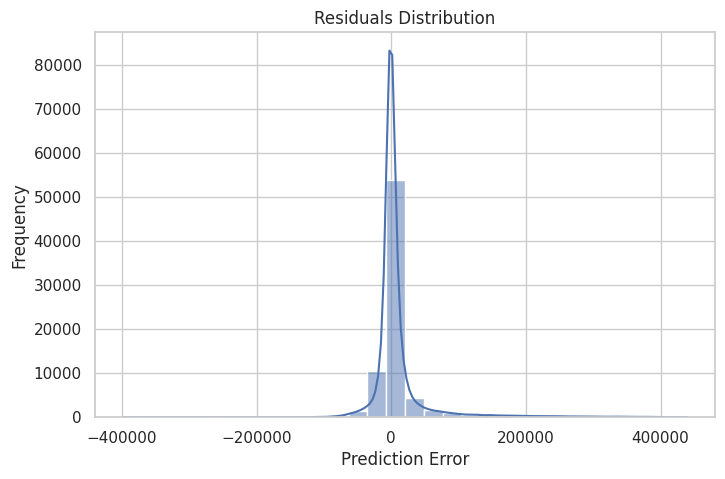

Model saved as 'xgb_model_pipeline.joblib'


In [63]:
# Predict on test set
y_pred_log = model_pipeline.predict(X_test)

# Convert predictions and true values back to original scale
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Calculate residuals

residuals = y_test_original - y_pred_original

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()
# Save the trained model pipeline for Streamlit
joblib.dump(model_pipeline, 'xgb_model_pipeline.joblib')

print("Model saved as 'xgb_model_pipeline.joblib'")


In [64]:
import numpy as np

# Select test samples from 1 to 4 (Python indexing excludes 5)
X_sample = X_test.iloc[1:5]

# Predict log(1 + EstProjectCost)
predicted_log1p = model_pipeline.predict(X_sample)

# Convert predictions back to original scale
predicted_original = np.expm1(predicted_log1p)

# Get actual log(1 + EstProjectCost) values for comparison
actual_log1p = y_test.iloc[1:5]

# Convert actual values back to original scale
actual_original = np.expm1(actual_log1p)

# Display results
for i in range(len(X_sample)):
    print(f"Sample {i+1}:")
    print(f"Predicted Log1p: {predicted_log1p[i]:.4f}, Predicted Original: {predicted_original[i]:.2f}")
    print(f"Actual Log1p:    {actual_log1p.iloc[i]:.4f}, Actual Original:    {actual_original.iloc[i]:.2f}")
    print('---')


Sample 1:
Predicted Log1p: 12.8489, Predicted Original: 380375.94
Actual Log1p:    12.8713, Actual Original:    388979.00
---
Sample 2:
Predicted Log1p: 11.7736, Predicted Original: 129779.72
Actual Log1p:    11.7651, Actual Original:    128679.00
---
Sample 3:
Predicted Log1p: 9.7953, Predicted Original: 17948.42
Actual Log1p:    10.3021, Actual Original:    29795.00
---
Sample 4:
Predicted Log1p: 7.8241, Predicted Original: 2499.05
Actual Log1p:    6.9088, Actual Original:    1000.00
---


In [65]:
df_filtered['EstProjectCost'].describe()

,EstProjectCost
count,378303.000000
mean,103540.542922
std,116799.371263
min,1.000000
25%,14175.000000
50%,42434.000000
75%,169821.000000
max,459192.000000


# Stratified Modeling of Project Cost Estimation

The stratified modeling approach is implemented to predict project costs more accurately by segmenting the data based on the magnitude of the project costs.

- **Objective:** Improve prediction accuracy by training separate models for small, medium, and large projects.
- **Target Variable:** Log-transformed estimated project cost (`LogEstProjectCost`).
- **Stratification:** Projects are grouped into three categories based on their original (exponentiated) cost values:
  - **Small projects:** Cost < \$14,000
  - **Medium projects:** \$14,000 ≤ Cost ≤ \$170,000
  - **Large projects:** Cost > \$170,000

Each group uses a dedicated XGBoost regression model, which is trained and evaluated independently to capture group-specific patterns effectively.

In [66]:
# Features and Target
model_features = ['TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits', 'AppliedYear',
                  'LocationCount', 'SqFtPerUnit', 'WorkClassMapped', 'PermitType', 'WorkClassGroup',
                  'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup',
                  'CommunityName_Top', 'StatusCurrent_Top']
target = 'LogEstProjectCost'

# Stratification Function
def stratify_project_cost(log_cost):
    cost = np.expm1(log_cost)
    if cost < 14000:
        return 'small'
    elif cost <= 170000:
        return 'medium'
    return 'large'

# Assign CostGroup
df_filtered['CostGroup'] = df_filtered[target].apply(stratify_project_cost)

# Categorical & Numerical Columns
categorical = ['WorkClassMapped', 'PermitType', 'WorkClassGroup', 'PermitClass_Top',
               'WorkClass', 'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top', 'StatusCurrent_Top']
numerical = ['TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits',
             'AppliedYear', 'LocationCount', 'SqFtPerUnit']

# Model Training Function
def train_group_model(df_group):
    X = df_group[model_features]
    y = df_group[target]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
])
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)

    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        tree_method='hist',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    model.fit(X_train_prep, y_train)

    return {'preprocessor': preprocessor, 'model': model}

# Train All Models
group_models = {}
for group_name in ['small', 'medium', 'large']:
    df_group = df_filtered[df_filtered['CostGroup'] == group_name]
    group_models[group_name] = train_group_model(df_group)

# Prepare Test Data
X_test = df_filtered[model_features]
y_test = df_filtered[target]
test_groups = df_filtered['CostGroup'].values
y_pred_log = np.zeros(len(X_test))

# Predict per group
for group in ['small', 'medium', 'large']:
    idxs = np.where(test_groups == group)[0]
    if len(idxs) == 0:
        continue
    X_group = X_test.iloc[idxs]
    X_group_prep = group_models[group]['preprocessor'].transform(X_group)
    preds = group_models[group]['model'].predict(X_group_prep)
    y_pred_log[idxs] = preds

# Evaluate
y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_log)

rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
r2_log = r2_score(y_test, y_pred_log)

rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2_orig = r2_score(y_test_orig, y_pred_orig)

print("\n Stratified Modeling Results:")
print(f"RMSE (Log Scale): {rmse_log:.4f}")
print(f"R² (Log Scale): {r2_log:.4f}")
print(f"RMSE (Original Scale): {rmse_orig:.2f}")
print(f"R² (Original Scale): {r2_orig:.4f}")


/tmp/ipython-input-1024700924.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




 Stratified Modeling Results:
RMSE (Log Scale): 0.4979
R² (Log Scale): 0.9062
RMSE (Original Scale): 22350.85
R² (Original Scale): 0.9634


## 🧠 Residual Analysis & Model Saving for Stratified model

Stratified models saved successfully.


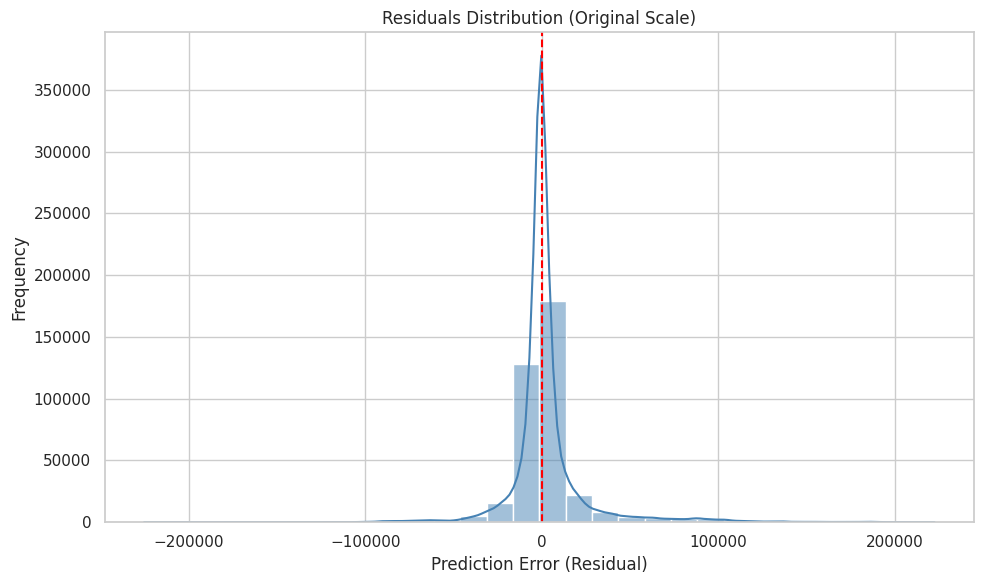

<Figure size 640x480 with 0 Axes>

In [67]:
# 1. Save each stratified model (preprocessor + model) with joblib
for group_name, model in group_models.items():
    joblib.dump(model, f'model_{group_name}.joblib')

print("Stratified models saved successfully.")

# 2. Calculate residuals for evaluation (original scale)
residuals = y_test_orig - y_pred_orig

# Optional: Combine into DataFrame for analysis
residual_df = pd.DataFrame({
    'Actual': y_test_orig,
    'Predicted': y_pred_orig,
    'Residual': residuals
})

# 3. Plot residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(residual_df['Residual'], bins=30, kde=True, color='steelblue')
plt.title("Residuals Distribution (Original Scale)")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

# 4. Save residual plot to file
plt.savefig('residual_plot.png')

# 🏗️ Calgary Permit Cost Estimation using Stratified Modeling and XGBoost

This following code demonstrates a two-step predictive modeling approach to estimate building permit costs:
1. Predicting log-transformed estimated costs using a trained XGBoost Regressor.
2. Classifying the cost group (small, medium, large).
3. Applying stratified regressors tailored to each cost group for fine-tuned predictions.

In [68]:
features=['TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits', 'AppliedYear',
    'LocationCount', 'SqFtPerUnit', 'WorkClassMapped', 'PermitType', 'WorkClassGroup',
    'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup',
    'CommunityName_Top', 'StatusCurrent_Top']
input_data=df_filtered.loc[:5,features]
input_data

,TotalSqFt,ApprovalDuration,CompletionDuration,HousingUnits,AppliedYear,LocationCount,SqFtPerUnit,WorkClassMapped,PermitType,WorkClassGroup,PermitClass_Top,WorkClass,ContractorName_Top,PermitClassGroup,CommunityName_Top,StatusCurrent_Top
0,1678.000000,15.0,192.0,1,2013,2.0,1678.0,New,Single Construction Permit,New,1106 - Single Family House,New,Other,Single Family,SADDLE RIDGE,Completed
1,1319.000000,28.0,189.0,1,2024,2.0,1319.0,New,Single Construction Permit,New,1106 - Single Family House,New,Other,Single Family,Other,Completed
4,2242.000000,9.0,208.0,1,2023,3.0,2242.0,New,Single Construction Permit,New,1106 - Single Family House,New,EXCEL HOMES LIMITED PARTNERSHIP,Single Family,Other,Completed
5,1488.749499,39.0,45.0,0,2023,6.0,0.0,Existing,Commercial / Multi Family Project,Improvement,3402 - Office,Alteration,Other,Commercial,DOWNTOWN COMMERCIAL CORE,Completed


In [69]:
# --- Step 1: Load Models ---
group_classifier = load("xgb_model_pipeline.joblib")  # XGB
model_small = load("model_small.joblib")             # Regressors
model_medium = load("model_medium.joblib")
model_large = load("model_large.joblib")

# --- Step 2: Load Input Data ---
# input_data = pd.read_csv("your_input_data.csv")  # Load your data
features = [col for col in input_data.columns if col not in ['EstProjectCost', 'LogEstProjectCost', 'CostGroup']]

def predict_group(log_cost):
    cost = np.expm1(log_cost)
    if cost < 14000:
        return 'small'
    elif cost <= 170000:
        return 'medium'
    return 'large'


# --- Step 3: Predict Group Using Classifier ---
input_data['log_cost_xgb'] = group_classifier.predict(input_data)
input_data['cost_xgb'] = np.expm1(input_data['log_cost_xgb'])
input_data['PredictedGroup'] = input_data['log_cost_xgb'].apply(predict_group)
# --- Step 4: Predict Cost Using Group-wise Model ---
log_preds = []
features=['TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits', 'AppliedYear',
    'LocationCount', 'SqFtPerUnit', 'WorkClassMapped', 'PermitType', 'WorkClassGroup',
    'PermitClass_Top', 'WorkClass', 'ContractorName_Top', 'PermitClassGroup',
    'CommunityName_Top', 'StatusCurrent_Top']
for idx, row in input_data.iterrows():
    group = row['PredictedGroup']
    X = pd.DataFrame([row[features]])

    if group == 'small':
        X_group_prep = model_small['preprocessor'].transform(X)
        log_pred = model_small['model'].predict(X_group_prep)[0]
    elif group == 'medium':
        X_group_prep = model_medium['preprocessor'].transform(X)
        log_pred = model_medium['model'].predict(X_group_prep)[0]
    elif group == 'large':
        X_group_prep = model_large['preprocessor'].transform(X)
        log_pred = model_large['model'].predict(X_group_prep)[0]
    else:
        log_pred = np.nan

    log_preds.append(log_pred)


input_data['Predicted_Log1p'] = log_preds
input_data['Predicted_Cost'] = np.expm1(input_data['Predicted_Log1p'])

input_data.head()

,TotalSqFt,ApprovalDuration,CompletionDuration,HousingUnits,AppliedYear,LocationCount,SqFtPerUnit,WorkClassMapped,PermitType,WorkClassGroup,...,WorkClass,ContractorName_Top,PermitClassGroup,CommunityName_Top,StatusCurrent_Top,log_cost_xgb,cost_xgb,PredictedGroup,Predicted_Log1p,Predicted_Cost
0,1678.000000,15.0,192.0,1,2013,2.0,1678.0,New,Single Construction Permit,New,...,New,Other,Single Family,SADDLE RIDGE,Completed,12.378237,237573.562500,large,12.431829,250653.171875
1,1319.000000,28.0,189.0,1,2024,2.0,1319.0,New,Single Construction Permit,New,...,New,Other,Single Family,Other,Completed,12.221008,203008.546875,large,12.283194,216033.546875
4,2242.000000,9.0,208.0,1,2023,3.0,2242.0,New,Single Construction Permit,New,...,New,EXCEL HOMES LIMITED PARTNERSHIP,Single Family,Other,Completed,12.796036,360783.375000,large,12.786788,357462.312500
5,1488.749499,39.0,45.0,0,2023,6.0,0.0,Existing,Commercial / Multi Family Project,Improvement,...,Alteration,Other,Commercial,DOWNTOWN COMMERCIAL CORE,Completed,11.730312,124281.484375,medium,11.073497,64439.449219


In [70]:
df_filtered.loc[:5,'EstProjectCost']
#print(df_filtered.loc[:0])


,EstProjectCost
0,246090.0
1,239531.0
4,357667.0
5,96078.0


In [71]:
df_filtered.columns

Index(['PermitNum', 'StatusCurrent', 'AppliedDate', 'IssuedDate',
       'CompletedDate', 'PermitType', 'PermitTypeMapped', 'PermitClass',
       'PermitClassGroup', 'PermitClassMapped', 'WorkClass', 'WorkClassGroup',
       'WorkClassMapped', 'Description', 'ApplicantName', 'ContractorName',
       'HousingUnits', 'EstProjectCost', 'TotalSqFt', 'OriginalAddress',
       'CommunityCode', 'CommunityName', 'Latitude', 'Longitude',
       'LocationCount', 'LocationTypes', 'LocationAddresses', 'LocationsWKT',
       'LocationsGeoJSON', 'Point', 'ApprovalDuration', 'CompletionDuration',
       'LogEstProjectCost', 'AppliedYear', 'CommunityName_Top',
       'StatusCurrent_Top', 'ContractorName_Top', 'PermitClass_Top',
       'SqFtPerUnit', 'CostGroup'],
      dtype='object')

# 🧾 Save Dropdown Options for Categorical Features using `joblib`

This section demonstrates how to extract unique values from categorical columns and save them as `.joblib` files. These files are later used in applications like Streamlit for populating dropdown menus.

In [72]:
# Assuming df_filtered is already defined
all_communities = df_filtered['CommunityName'].dropna().unique().tolist()

# Save full list of community names
joblib.dump(all_communities, "CommunityName_all.joblib")

['CommunityName_all.joblib']

In [73]:
# Example: existing top communities list
top_communities = df_filtered['CommunityName_Top'].dropna().unique().tolist()

# Save the top list
joblib.dump(top_communities, "CommunityName_Top.joblib")


['CommunityName_Top.joblib']

In [74]:
# Get all unique contractor names
all_contractors = df_filtered['ContractorName'].dropna().unique().tolist()

# Save to joblib
joblib.dump(all_contractors, "ContractorName_all.joblib")

['ContractorName_all.joblib']

In [75]:
# Get top contractor names used in modeling
top_contractors = df_filtered['ContractorName_Top'].dropna().unique().tolist()

# Save to joblib
joblib.dump(top_contractors, "ContractorName_Top.joblib")

['ContractorName_Top.joblib']

In [76]:
import joblib
import pandas as pd

# List of columns you want to extract unique values from
categorical_columns = [
    'PermitType', 'PermitTypeMapped',
    'PermitClassGroup', 'PermitClassMapped', 'WorkClass',
    'WorkClassGroup', 'WorkClassMapped',
    'StatusCurrent_Top', 'PermitClass_Top'  # Make sure these column names are correct
]

# Load your DataFrame (replace this with your actual data)
# df = pd.read_csv("your_permit_data.csv")

# Loop through columns and save unique values
for col in categorical_columns:
    if col in df_filtered.columns:
        unique_values = df_filtered[col].dropna().unique().tolist()
        joblib.dump(unique_values, f"{col}_options.joblib")
    else:
        print(f"Column '{col}' not found in DataFrame.")


# Project Cost Prediction – XGBoost + Stratified Models

## 🎯 Objective
Estimate project costs using a two-step approach:
1. General XGBoost model for initial cost prediction.
2. Stratified models for refined predictions by cost group.

---

## 🔢 Steps

### 1. Load Models
- General: `xgb_model_pipeline.joblib`
- Group-specific: `model_small`, `model_medium`, `model_large`

### 2. Initial Prediction
- Predict `log(1 + EstProjectCost)` using XGBoost.
- Convert to cost with `expm1`.

### 3. Group Classification
- Cost < 14K → Small  
- 14K–170K → Medium  
- >170K → Large

### 4. Stratified Prediction
- Apply matching regressor based on group.
- Predict refined `log(1 + cost)` → convert to cost.

### 5. Error Metrics
- Calculate `AbsoluteError` (stratified)
- Compare with `XGB_AbsoluteError`

---

## 📤 Output
Save results to:
- `predicted_vs_actual_results.csv`
- `predicted_vs_actual_results.xlsx`

Includes actual, predicted, group label, and error columns – ready for Power BI.

---


In [77]:
# Load models
group_classifier = load("xgb_model_pipeline.joblib")
model_small = load("model_small.joblib")
model_medium = load("model_medium.joblib")
model_large = load("model_large.joblib")

# Copy to result df
df_result = df_filtered.copy()

# Define feature columns
features = [
    'TotalSqFt', 'ApprovalDuration', 'CompletionDuration', 'HousingUnits',
    'AppliedYear', 'LocationCount', 'SqFtPerUnit', 'WorkClassMapped',
    'PermitType', 'WorkClassGroup', 'PermitClass_Top', 'WorkClass',
    'ContractorName_Top', 'PermitClassGroup', 'CommunityName_Top',
    'StatusCurrent_Top'
]

# Step 1: Predict with XGB Classifier
df_result['log_cost_xgb'] = group_classifier.predict(df_result)
df_result['cost_xgb'] = np.expm1(df_result['log_cost_xgb'])

# Predict Group
def predict_group(log_cost):
    cost = np.expm1(log_cost)
    if cost < 14000:
        return 'small'
    elif cost <= 170000:
        return 'medium'
    return 'large'

df_result['PredictedGroup'] = df_result['log_cost_xgb'].apply(predict_group)

# Step 2: Predict using group-specific regressors (vectorized)
df_result['Predicted_Log1p'] = np.nan

for group, model in zip(['small', 'medium', 'large'], [model_small, model_medium, model_large]):
    group_mask = df_result['PredictedGroup'] == group
    if group_mask.sum() == 0:
        continue

    X_group = df_result.loc[group_mask, features]
    X_group_prepped = model['preprocessor'].transform(X_group)
    df_result.loc[group_mask, 'Predicted_Log1p'] = model['model'].predict(X_group_prepped)

# Step 3: Calculate predicted cost
df_result['Predicted_Cost'] = np.expm1(df_result['Predicted_Log1p'])

# Step 4: Error metrics
df_result['Error'] = df_result['Predicted_Cost'] - df_result['EstProjectCost']
df_result['AbsoluteError'] = df_result['Error'].abs()
df_result['XGB_AbsoluteError'] = (df_result['cost_xgb'] - df_result['EstProjectCost']).abs()

## Step 5: Save
#df_result.to_csv("predicted_vs_actual_results.csv", index=False)
# Step 5: Save to Excel
df_result.to_excel("predicted_vs_actual_results.xlsx", index=False)

## ✅ Model Comparison: XGBoost vs Stratified Regressors

### 🔍 Error Summary (Absolute Error in $)
| Metric      | XGBoost          | Stratified         |
|-------------|------------------|---------------------|
| Mean        | \$17,745.98       | \$18,237.49          |
| Std Dev     | \$41,243.05       | \$42,756.55          |
| Median      | \$5,344.30        | \$5,439.76           |
| Max         |\$441,666.32      |\$448,704.51         |

### 📌 Decision:
Although stratified models were introduced for refined group-level predictions, the **XGBoost model consistently performs slightly better or comparably across key metrics** (mean, median, and max error). In some cases, incorrect group classification negatively affects the stratified model quality.

👉 Therefore, we will **proceed with the XGBoost predictions** as the final output for Power BI and further analysis.



In [78]:
df_result[['XGB_AbsoluteError','AbsoluteError']].describe()

,XGB_AbsoluteError,AbsoluteError
count,378303.000000,378303.000000
mean,17745.975776,18237.490756
std,41243.050169,42756.549943
min,0.031250,0.002908
25%,2122.817627,2050.185865
50%,5344.296875,5439.763408
75%,13905.390625,14606.604704
max,441666.318359,448704.510093


# ✅ Conclusion

- Group-wise modeling (e.g., Small / Medium / Large permits) shows **potential for improved predictive performance** by tailoring models to the characteristics of each segment.
- Traditional ensemble models like XGBoost and CatBoost already provide strong results, but **further performance gains may be possible** with deep learning.
- Introducing structured categorization at the **data entry stage** (e.g., permit size/type) could enhance both model training and operational prediction accuracy.

## 🔜 Next Steps

- ✅ **Model Performance Review**:
  - Evaluate and compare RMSE/R² of traditional vs. group-based models.
  - Validate benefit of group-specific training pipelines.

- ✅ **Deep Learning Exploration**:
  - Build and test **Neural Network models** (e.g., DNN with dense layers) for regression.
  - Consider **tabular DL frameworks** like [TabNet](https://arxiv.org/abs/1908.07442), [FT-Transformer](https://arxiv.org/abs/2106.11959), or [SAINT](https://arxiv.org/abs/2106.01342) for enhanced performance.
  - Use **embedding layers** for categorical features and **batch normalization** to improve convergence.

- ✅ **Data Engineering**:
  - Propose inclusion of group labels (Small/Medium/Large) in **permit application forms**.
  - Evaluate benefits of **feature engineering vs. representation learning** in DL models.

- ✅ **Model Deployment Roadmap**:
  - Benchmark deep learning models against tree-based models.
  - Assess inference time, explainability, and integration feasibility with city planning tools.
